<ul style="background-color:#F9E9C6;"> 

### Legi-Nr. 01-920-446
    
<u1/>

# SLT-CE-3: Histogram Clustering

In this coding exercise, you will segment an image with histogram clustering (HC). You will implement two different methods: maximum a posterior probability (MAP) and deterministic annealing (DA) for predicting the cluster membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

[1] Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981 

[2] Lecture Slides 5: https://ml2.inf.ethz.ch/courses/slt/lectures/slt21_lecture05.pdf

[3] Lecture script: https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT_Script.pdf, chapter 2.7

<h2 style="background-color:#f0b375;"> Setup </h2>

In [14]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread

# to loop over cartesian products
from itertools import product 

# for cluster matching
from scipy.optimize import linprog

import pandas as pd
from sklearn.metrics import confusion_matrix

## Texture and corresponding label map
(This texture is used to fit your model.)

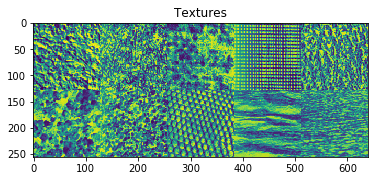

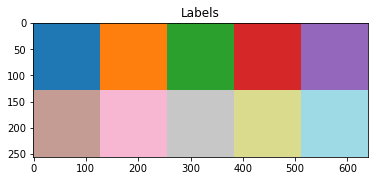

In [15]:
texture = imread("texture.png")

patch_grid_shape = (2, 5)
patch_shape = (128, 128)
label_map = np.ones(texture.shape)

for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)] = np.ravel_multi_index((i, j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

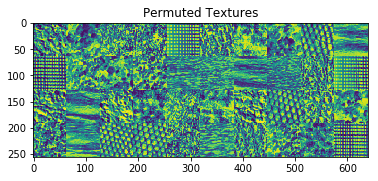

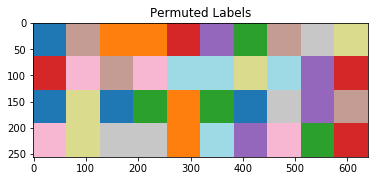

In [16]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i // 2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape) * np.array(perm_patch_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape) * np.array(perm_patch_shape)

    perm_texture[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = texture[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

    perm_label_map[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = label_map[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both: maximum a posteriori probability estimation (MAP) and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference <a href=http://ieeexplore.ieee.org/document/784981>[1]</a> looks for the case of DA (using the notation of reference [1]).<br>
Hint: try to derive $\hat P(y|c)$ from $\hat P(c|x)$ and use the maximum entropy principle to find $\hat P(c|x)$.
</p>

<ul style="background-color:#F9E9C6;"> 

In the following let $\mathbf{X}$ denote the set of objects considered with arbitrary labeling and $\mathbf{Y}$ the domain of nominal features. (Potential) observations correspond to pairs $(x,y)\in\mathbf{X}\times\mathbf{Y}.$ 
Given set of observations $\mathcal{D}:=\{(x_i,y_i):i=1,\ldots,l\}$, we define
$$n(x,y):=\sum_{i=1}^{l}\delta_{x,x_i}\cdot \delta_{y,y_i}$$ 
the number of observations of object $x$ together with features $y$ and its marginal $n(x):=\sum_{y} n(x,y).$

#### maximum a posteriori probability estimation (MAP) 
Following parameters are estimated as follows:

\begin{align}
    \hat{\mathbb{P}}(x) &= \cfrac{n(x)}{\sum_{x' \in X} n(x')}, \hspace{1em}\text{probability distribution of an object x ,}\\
    \hat{\mathbb{P}} (y|c) &= \sum_{x: \hat{c}(x) = c} \cfrac{n(x)}{\sum_{x': \hat{c}(x') = c} n(x')} \hat{\mathbb{P}} (y|x),\hspace{1em}\text{weighted feature-distribution for a given assignment function (cf. update-step for $k$-means, E-step) ,} \\
    \hat{c}(x) &= \underset{a}{\operatorname{argmin}} \left(- \sum_{y } \hat{\mathbb{P}} (y|x) \cdot log \hat{\mathbb{P}}(y|a)- log \mathbb{P}(\hat{c}_a^x) \right),
    \hspace{1em}\text{cluster assignment for given distributions (cf. assignment-step for $k$-means, M-step),}
\end{align}
where 
$$\hat{c}_a^x(x') = 
\begin{cases} 
    a,&\text{for } x'=x,\\
    \hat{c}(x'),&\text{for } x'\neq x
\end{cases}$$
for a given assignment $\hat{c}$.
The log-posterior distribution resp. $\mathbf{L}(c,\theta;\mathbf{n})$ (Equation (3) in <a href=http://ieeexplore.ieee.org/document/784981>[1]</a>) can then be maximized by alternatingly using an update- and assignment step similarly to $k$-means.


#### Deterministic Annealing estimation (DA)

In contrast to the MAP estimation, Deterministic Annealing (DA) uses a fuzzy instead of a hard assignment. Equation (5) of reference <a href=http://ieeexplore.ieee.org/document/784981>[1]</a> becomes then

\begin{align}
    \hat{\mathbb{P}}(y\vert x) &= \cfrac{\sum_{x\in X} \hat{\mathbb{P}}(y\vert x)\cdot \mathbb{P}_{x,c}}{\sum_{x\in X}  \mathbb{P}_{x,c}} \hspace{1em}\text{with }\mathbb{P}_{x,c}\text{ being the assignment probability of x to c.}
\end{align}

For a given temperature $T>0$, this assignment probability is determined as a Gibbs-distribution as follows:

\begin{align}
    \hat{\mathbb{P}}(y\vert x) &= \cfrac{\exp(-\frac{1}{T}DK_{KL}(\hat{\mathbb{P}}(y\vert x)\lVert\hat{\mathbb{P}}(y\vert c))}{\sum_{a}  \exp(-\frac{1}{T}DK_{KL}(\hat{\mathbb{P}}(y\vert x)\lVert\hat{\mathbb{P}}(y\vert a))} \hspace{1em}\text{with }DK_{KL}\text{ denoting the Kullback-Leibler divergence.}
\end{align}

During the usual cooling process, i.e. lowering the temperature stepwise to (almost) zero, optimal centroids are determined by an EM-like algorithm; cf. last assignment on DA.

<u1/>

<ul style="background-color:#F9E9C6;"> 

Some helper functions needed later.
    
<u1/>

In [17]:
def best_perm(A, perm_matrix=False):
    '''
    Returns the permutation maximizing the diagonal
    Slightly adapted from Paul Panzer, https://stackoverflow.com/a/48512140
    '''
    n, n = A.shape
    res = linprog(-A.ravel(),
                  A_eq=np.r_[np.kron(np.identity(n), np.ones((1, n))),
                             np.kron(np.ones((1, n)), np.identity(n))],
                  b_eq=np.ones((2*n,)), bounds=n*n*[(0, None)])
    assert res.success
    
    perm = res.x.reshape(n, n).T
    A_perm = np.matmul(A, perm).astype(np.int64)
    
    if perm_matrix:
        return A_perm, perm
    
    return A_perm


def replace_with_dict(ar, dic):
    '''
    Replaces array values based on a dictionary.
    Credits: Divakar, https://stackoverflow.com/a/47171600
    '''
    
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    ks = k[sidx]
    vs = v[sidx]
    
    return vs[np.searchsorted(ks,ar)]


def perm_labels(label_map, pred_label_map):
    '''
    Permutes predicted labels to match original clustering labels optimally 
    '''
    
    # get permutation matrix
    _, P = best_perm(confusion_matrix(np.ravel(pred_label_map), np.ravel(label_map)), perm_matrix=True)
   
    # create dictionary for permutation
    perm_dict = dict(np.argwhere(P.T > 0))
    
    # return permuted label map
    perm_pred_label_map = replace_with_dict(pred_label_map, perm_dict)

    return perm_pred_label_map


def perm_plot(label_map, pred_label_map):
    '''
    Plots permutated prediction labels next original clustering labels 
    '''
    
    perm_pred_label_map = perm_labels(label_map, pred_label_map)
    
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.imshow(label_map, cmap="tab20")
    plt.title("Original Labels")
    plt.subplot(122)
    plt.imshow(perm_pred_label_map, cmap="tab20")
    plt.title("Predicted and Permutated Labels")
    plt.show()

In [18]:
class HistogramClustering_2(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)
    
    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).
        
    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """
    
    def __init__(self, n_clusters=10, n_bins=128, window_size=15, random_state=47, estimation="MAP", 
                top_neighs=3, top_B=1, top_lambda=1e-6):
        self.n_clusters = n_clusters
        self.n_bins = n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        # Add more parameters, if necessary.
        self.top_neighs = top_neighs
        self.top_B = top_B
        self.top_lambda = top_lambda
    
    def get_patches(self, X, ws=None):
        ws = self.window_size if ws is None else ws
        " patches.shape: (n_pixels, self.window_size, self.window_size) "
        paddim = int(ws/2 - 0.5)
        padmat = ((paddim,paddim),(paddim,paddim))
        padded = np.lib.pad(X, padmat, 'constant', constant_values=((-1, -1),(-1, -1)))
        patches = image.extract_patches_2d(padded, (ws, ws))
        return patches
    
    def get_hist(self, patch, normalize=False):
        hist = np.histogram(patch[patch>-1], bins=np.linspace(0,1,self.n_bins+1))[0]
        return hist/np.sum(hist) if normalize else hist
    
    def topological_prior(self, assignments):    
        prior_patches = self.get_patches(assignments, ws=self.top_neighs)
        height = assignments.shape[0]
        width = assignments.shape[1]
        prior_patches = np.reshape(prior_patches, (height, width, self.top_neighs, self.top_neighs))
        H_mat = np.zeros((height, width))
        for i in range(0, height):
            for j in range(0, width):
                a_patch = prior_patches[i,j,:,:]
                paddim = int(self.top_neighs/2 - 0.5)
                patch_class = a_patch[paddim,paddim]
                A_x = np.count_nonzero(a_patch == patch_class)-1
                H_mat[i,j] = self.top_B - A_x
                if H_mat[i,j] < 0:
                    H_mat[i,j] = 0
        H_vals = np.zeros((self.n_clusters, 1))
        for cid in range(0, self.n_clusters):
            ass_c = np.where(assignments == cid)[0]
            H_c = np.sum(H_mat[assignments == cid])
            H_vals[cid] = H_c
        priors = np.exp(-self.top_lambda * H_vals)
        priors = priors/np.sum(priors)
        return priors
    
    def fit_MAP(self, X, hists):

        height = X.shape[0]
        width = X.shape[1]
        n_pixels = height * width

        # Calculate histograms
        if hists is None:
            patches = self.get_patches(X)
            hists = np.apply_along_axis(self.get_hist, 1, np.reshape(patches, (n_pixels, -1)), True)
        self.train_hists = hists

        # Initialize centroids as random
        self.centroids = np.random.rand(self.n_clusters, self.n_bins)
        self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])

        assignments = np.zeros((n_pixels, 1), dtype=int)
        cluster_sizes = np.zeros((self.n_clusters, 1), dtype=int)

        # Initialize assignments by assigning points to nearest centroid
        cost_mat = -np.matmul(hists, np.log(self.centroids).T)
        assignments = np.expand_dims(np.argmin(cost_mat, axis=1), axis=1)

        for cid in range(0, self.n_clusters):
            cs = np.where(assignments == cid)[0].size
            cluster_sizes[cid] = cs

        epoch = 0
        while True:

            epoch = epoch+1
            change = False
            old_ass = assignments.copy()

            # Equation 5, calculate centroid histograms
            for cid in range(0, self.n_clusters):
                xids = np.where(assignments == cid)[0]
                # (also calculate centroid probabilities)
                cluster_sizes[cid] = xids.size
                if xids.size == 0:
                    print('Empty cluster')
                self.centroids[cid] = np.mean(hists[xids], axis=0)
            # Add a minuscule non-zero value for numerical stability
            self.centroids = self.centroids + 1e-8

            # Equation 6, calculate pixel assignments
            assignments = np.reshape(assignments, (-1, 1))
            cost_mat = -np.matmul(hists, np.log(self.centroids).T)
            priors = np.squeeze(self.topological_prior(assignments))
            # cost_mat = cost_mat - np.log(priors)
            # cluster_probas = np.squeeze(cluster_sizes/np.sum(cluster_sizes))
            assignments = np.expand_dims(np.argmin(cost_mat, axis=1), axis=1)
            if np.sum(assignments - old_ass) != 0:
                change = True

            if not change:
                break

        self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])
        return self
    
    def fit_DA(self, X, hists, test_hists=None):

        height = X.shape[0]
        width = X.shape[1]
        n_pixels = height * width

        # Calculate histograms
        if hists is None:
            patches = self.get_patches(X)
            hists = np.apply_along_axis(self.get_hist, 1, np.reshape(patches, (n_pixels, -1)), True)
        self.train_hists = hists
        

        # Initialize centroids
        init_center = np.mean(hists, axis=0)
        print('init: ',init_center.shape)
        self.centroids = np.repeat(init_center[np.newaxis,:], self.n_clusters, axis=0)
        print('self.centroids 1: ',self.centroids.shape)
        self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])
        print('self.centroids 2: ',self.centroids.shape)
        # Initialize probabilities
        p = np.ones((n_pixels, self.n_clusters), dtype='float32') / self.n_clusters
        #pc_list = np.ones((self.n_clusters,1), dtype='float32') / self.n_clusters
        p_x = 1.0 / n_pixels
        
        print('p: ',p.shape)
        # print('p_x: ',p_x.shape)
        
        # Initial temperature
        T = 0.3
        # T_min for stopping the algorithm
        self.T_cutoff = 0.17
        # For the final calculation
        self.T_zero = 10e-3
        # Epsilon for closeness check
        epsilon = 0.002
        # Cooling rate
        alpha = 0.5
        
        
        while True:
            print('T =', T)
            
            # Perturb centroids if too close to each other
            for i in range(0, self.n_clusters):
                for j in range(0, self.n_clusters):
                    if i != j and np.linalg.norm(self.centroids[i] - self.centroids[j]) < epsilon:
                        noise = np.random.normal( scale=epsilon, size=self.centroids[j].shape )
                        #self.centroids[j] = self.centroids[j] + np.random.normal(0, .1, self.centroids[j].shape)
                        self.centroids[j] = self.centroids[j] + noise
                        self.centroids[j][ self.centroids[j] < 0 ] = np.abs( self.centroids[j][ self.centroids[j] < 0 ] )
                        self.centroids[j][ self.centroids[j] >  1 ] = 2 - self.centroids[j][ self.centroids[j] >  1 ]
            self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])
            
            k=0
            while True:
                # p: (n_pixels, n_clusters)
                # hists: (n_pixels, n_bins)
                # p[:,k]: (n_pixels, )
                
                old_centroids = self.centroids.copy()
                print('--- {} shape {} ------'.format(k, old_centroids.shape))
                k+=1 
                
                # Expectation step, centroids are fixed
                '''
                # Iterative version:
                kls = []
                for k in range(0, self.n_clusters):
                    div = np.divide(hists, self.centroids[k] + 10e-4)
                    temp = np.multiply(hists, np.log(div + 10e-10))
                    kl = -np.sum(temp, axis=1) / T
                    kls.append(kl)
                '''
                
                # set_trace()
                # Vectorised version:
                kls = np.array([-np.sum(np.multiply(hists, np.log(np.divide(hists, k + 10e-4) + 10e-10)), axis=1) / T 
                       for k in self.centroids])
                #kls = kls - np.max(kls, axis=0)
                kls = np.exp(kls)
                p = np.moveaxis(kls/np.sum(kls, axis=0), 0, 1) 
                
                # Maximization step, assignments are fixed
                '''
                # Iterative version:
                for k in range(0, self.n_clusters):
                    nom = np.sum(hists * p[:,k][:,np.newaxis], axis=0)
                    denom = np.sum(p[:,k])
                    print(denom)
                    self.centroids[k] = nom / denom
                '''
                # Vectorised version:
                nom = np.matmul(p.T, hists)
                denom = np.sum(p, axis=0)[:,np.newaxis]
                self.centroids = nom / denom
                self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])
                    
                # diffs = np.linalg.norm(old_centroids - self.centroids)
                diffs = np.sqrt(np.sum(np.power(old_centroids - self.centroids, 2)))
                if diffs < 1e-4:
                    break

            # Show predictions after each EM convergence
            if(True):
                train_pred = self.predict(X, hists, T=T)
                matched_preds = match_maps(label_map, train_pred, 10)[0]
                plt.figure(figsize=(16,4))
                plt.subplot(121)
                plt.imshow(label_map, cmap="tab20")
                plt.subplot(122)
                plt.imshow(matched_preds, cmap="tab20")
                plt.show()
            
                if test_hists is not None:
                    test_pred = self.predict(X, test_hists, T=T)
                    matched_preds = match_maps(perm_label_map, test_pred, 10)[0]
                    plt.figure(figsize=(16,4))
                    plt.subplot(121)
                    plt.imshow(perm_label_map, cmap="tab20")
                    plt.subplot(122)
                    plt.imshow(matched_preds, cmap="tab20")
                    plt.show()

            if T == self.T_zero:
                return self
            elif T < self.T_cutoff:
                T = self.T_zero
            else:
                T = alpha * T
    
    def fit(self, X, hists=None, test_hists=None):
        """Compute HC for input image X
        
        Compute centroids.        
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
        
        Returns:
            self
        """
        random.seed(self.random_state)
        np.random.seed(self.random_state)
        
        if self.estimation == "MAP":
            
            # Code for Maximum a Posteriori estimation
            self.fit_MAP(X, hists)
        
        elif self.estimation == "DA":
            
            # Code for Deterministic Annealing estimation
            self.fit_DA(X, hists, test_hists)
        
        return self
    
    def predict(self, X, hists=None, T=None):
        """Predict cluster assignments for each pixel in image X.
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
            
        Returns:
            C (np.ndarray): Assignment map (height, width) 
        """
        check_is_fitted(self, ["centroids"])
        
        height = X.shape[0]
        width = X.shape[1]
        n_pixels = height * width

        # Calculate histograms
        if hists is None:
            patches = self.get_patches(X)
            hists = np.apply_along_axis(self.get_hist, 1, np.reshape(patches, (n_pixels, -1)), True)
            self.test_hists = hists

        if self.estimation == "MAP":
            cost_mat = -np.matmul(hists, np.log(self.centroids).T)
            assignments = np.expand_dims(np.argmin(cost_mat, axis=1), axis=1)
            C = np.reshape(assignments, (height, width))
        if self.estimation == "DA":
            if T is None:
                T = self.T_zero
            kls = np.array([-np.sum(np.multiply(hists, np.log(np.divide(hists, k + 10e-4) + 10e-10)), axis=1) / T 
                   for k in self.centroids])
            #kls = kls - np.max(kls, axis=0)
            kls = np.exp(kls)
            p = np.moveaxis(kls/np.sum(kls, axis=0), 0, 1)
            assignments = np.argmax(p, axis=1)
            C = np.reshape(assignments, (height, width))

        return C
    
    def generate(self, C):
        """Generate a sample image X from a texture label map C.
        
        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).
        
        Args:
            C (np.ndarray): Input array with shape (height, width)
            
        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])
        
        # Your code goes here
        
        X = np.zeros(C.shape)
        height = patch_shape[0]
        width = patch_shape[1]
        discret = np.linspace(0, 1, self.n_bins+1)
        for h in range(0, height):
            for w in range(0, width):
                cs = np.cumsum(self.centroids[C[h,w]])
                choice = random.random()
                bin_idx = np.where(np.array(choice < cs, dtype=int) == 1)[0][0]
                X[h,w] = np.random.uniform(discret[bin_idx],discret[bin_idx+1],1)
        
        return X
        

In [19]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)
    
    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).
        
    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """
    
    def __init__(self, n_clusters=10, n_bins=128, window_size=15, random_state=42, estimation="MAP", max_it=100, plot_fit=False):
        self.n_clusters = n_clusters
        self.n_bins = n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation

        # Add more parameters, if necessary.
        self.max_it = max_it
        self.plot_fit = plot_fit
        
    # TODO ***********************************************************************   
    def get_patches(self, X, ws=None):
        ws = self.window_size if ws is None else ws
        " patches.shape: (n_pixels, self.window_size, self.window_size) "
        paddim = int(ws/2 - 0.5)
        padmat = ((paddim,paddim),(paddim,paddim))
        padded = np.lib.pad(X, padmat, 'constant', constant_values=((-1, -1),(-1, -1)))
        patches = image.extract_patches_2d(padded, (ws, ws))
        return patches
    
    def get_hist(self, patch, normalize=False):
        hist = np.histogram(patch[patch>-1], bins=np.linspace(0,1,self.n_bins+1))[0]
        return hist/np.sum(hist) if normalize else hist
    # ***********************************************************************
    
    
    def fit(self, X):
        """Compute HC for input image X
        
        Compute centroids.        
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
        
        Returns:
            self
        """
        
        # initialize
        estimation = self.estimation
        n_clusters = self.n_clusters
        n_bins = self.n_bins
        wind_size = self.window_size
        plot_fit = self.plot_fit
        max_it = self.max_it
        
        height, width = X.shape
        n_pixels = height * width
        
        # create histogram
        _, self.bin_edges = np.histogram(X, n_bins)
        bin_edges = self.bin_edges  # used for patches later
        
        # feature distribution for a given x      
        n_y_x = np.zeros([height, width, n_bins])
        p_y_x = np.zeros([height, width, n_bins])
        
        # determine patch coordinates (floored and capped appropriately)
        # assign histogram (features) to patch 
        for i,j in product(range(height), range(width)):                    
            i1 = np.max([i - wind_size//2, 0])
            i2 = np.min([i + wind_size//2 + 1, height])
            j1 = np.max([j - wind_size//2, 0])
            j2 = np.min([j + wind_size//2 + 1, width])
            n_y_x[i,j], _ = np.histogram(X[i1: i2, j1: j2], bin_edges)
            # print("CHECK - ",i,j,"_",np.sum(n_y_x[i,j]))
            # print("CHECK - ",i1,i2,j1,j2,"_",np.sum(X[i1: i2, j1: j2]))
        
        self.feats_fit = n_y_x  # features from fitting process
        
        nx = np.sum(n_y_x, axis = 2)
        
        # normalize
        for i,j in product(range(height), range(width)):
            p_y_x[i,j] = n_y_x[i,j] / nx[i,j]
            # if nx[i,j]==0: print(i,j," sum {}".format(np.sum(nx))," - DIVIDE ZERO")
        
        
        if self.estimation == "MAP":

            # feature y distribution for clusters c
            # initialize to uniform distribution
            p_y_c = 1/ n_bins * np.ones([n_bins, n_clusters])
            
            # initial: random assignment to clusters 
            c_assign = np.random.randint(n_clusters, size= (height, width)) 
            
            # EM-algorithm
            # while np.any(eps > tol):
            
            ##### TODO -  BETTER Conv criteria
            
                        ##### TODO -  BETTER Conv criteria
            ##### TODO -  BETTER Conv criteria

            # print('Max it: ', max_it)
            for l in range(max_it):
                
                
                p_y_c_old = p_y_c.copy()
                # c_assign_old = c_assign.copy()
                
                # 1. update step of probabilities (E-step)
                for c in range(n_clusters):
                    
                    i, j = np.where(c_assign == c)
                    nx_c = np.sum(nx[i, j]) # sum over all objects with assignment c              
                    # p_y_c = np.dot(nx[i, j], p_y_x[i, j])
                    
                    
                    if nx_c != 0:  # if there are corresponding objects, update conditional distribution
                        p_y_c[:, c] = np.dot(nx[i, j], p_y_x[i, j]) / nx_c
                        
                    else:  # else, use "least informative" one, i.e. the uniform one
                        p_y_c[:, c] = 1/n_bins* np.ones([n_bins]) 
                    
                # TODO 
                # avoid taking logarithm of zero
                p_y_c[np.where(p_y_c == 0)] = 1e-5

                # 2. update assignments (M-step)
                # Note we are assuming a uniform prior and thus can crop the last term c_hat_x_a
                
                c_assign = np.argmin(- np.dot(p_y_x, np.log(p_y_c)), axis = 2)
                
                self.centroids = p_y_c

        elif self.estimation == "DA":
            
            # TODO ***********************************************************************
                    
            # Calculate histograms
            
            patches = self.get_patches(X)
            hists_2 = np.apply_along_axis(self.get_hist, 1, np.reshape(patches, (n_pixels, -1)), True)
            self.train_hists_2 = hists_2
            
                    # Initialize centroids
            init_center_2 = np.mean(hists_2, axis=0)
            self.centroids_2 = np.repeat(init_center_2[np.newaxis,:], self.n_clusters, axis=0)
            self.centroids_2 = np.divide(self.centroids_2, np.sum(self.centroids_2, axis=1)[:, np.newaxis])
            # TODO ***********************************************************************
                    

            # Code for Deterministic Annealing estimation
            
            # Initialize centroids
            centroid_init = np.mean(self.feats_fit, axis=(0,1))
            self.centroids = np.repeat(centroid_init[np.newaxis,:], self.n_clusters, axis=0)
            self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])
            # set_trace()

            # feature y distribution for clusters c
            # initialize to uniform distribution
            p = np.ones((n_pixels, self.n_clusters), dtype='float32') / self.n_clusters
            # set_trace()
            #pc_list = np.ones((self.n_clusters,1), dtype='float32') / self.n_clusters
            p_x = 1.0 / n_pixels
            
            #p_y_c = 1/ n_bins * np.ones([n_bins, n_clusters])  # p
            
            # initial: random assignment to clusters 
            # c_assign = np.random.randint(n_clusters, size= (height, width)) 
            
            # Initial temperature
            T_init = 0.3
            # threshold temperature
            self.T_min = 0.1
            # final tempertaur
            self.T0 = 0.001
            # Epsilon for closeness check
            epsilon = 0.002
            # Cooling rate
            self.alpha = 0.9
            
            T = T_init
            
            t_loop_counter = -1
            
            
            # set_trace()
            # loop over temperatures 
            while T >= self.T_min:
                
                         # Perturb centroids if too close to each other
                for i in range(0, self.n_clusters):
                    for j in range(0, self.n_clusters):
                        if i != j and np.linalg.norm(self.centroids[i] - self.centroids[j]) < epsilon:
                            noise = np.random.normal( scale=epsilon, size=self.centroids[j].shape )
                            #self.centroids[j] = self.centroids[j] + np.random.normal(0, .1, self.centroids[j].shape)
                            self.centroids[j] = self.centroids[j] + noise
                            self.centroids[j][ self.centroids[j] < 0 ] = np.abs( self.centroids[j][ self.centroids[j] < 0 ] )
                            self.centroids[j][ self.centroids[j] >  1 ] = 2 - self.centroids[j][ self.centroids[j] >  1 ]
                            self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])

                
            
                # Perturb centroids if too close to each other
                for i in range(0, self.n_clusters):
                    for j in range(0, self.n_clusters):
                        if i != j and np.linalg.norm(self.centroids_2[i] - self.centroids_2[j]) < epsilon:
                            noise = np.random.normal( scale=epsilon, size=self.centroids_2[j].shape )
                            #self.centroids[j] = self.centroids[j] + np.random.normal(0, .1, self.centroids[j].shape)
                            self.centroids_2[j] = self.centroids_2[j] + noise
                            self.centroids_2[j][ self.centroids_2[j] < 0 ] = np.abs( self.centroids_2[j][ self.centroids_2[j] < 0 ] )
                            self.centroids_2[j][ self.centroids_2[j] >  1 ] = 2 - self.centroids_2[j][ self.centroids_2[j] >  1 ]
                self.centroids_2 = np.divide(self.centroids_2, np.sum(self.centroids_2, axis=1)[:, np.newaxis])

                
                t_loop_counter += 1
                print(t_loop_counter,' --- temperature: ',T )
                # if self.verbose: print('counter: {} -- temperature : {}'.format(t_loop_counter,T))               
                
                # Loop for EM-Algorithm
                EM_counter = -1
                
                while True:
                    EM_counter += 1
                    
                    print(EM_counter,' --- EM_counter.')
                    # STEP 3
                    # E-step
                    prev_centroids = self.centroids.copy()
                    # self.cluster_centers.copy()  # previous centroids
                    #distance_sq = self.get_distance(samples, prev_centroids)
                    #self.cluster_probs = self._calculate_cluster_probs(distance_sq, T)
                    # set_trace()
                    hists = self.feats_fit
                    hists = hists.reshape(-1, hists.shape[-1]) 
                    # hists = hists / np.sum(hists, axis = 1)
                    # hists = hists/np.expand_dims(np.sum(hists, axis=1), 1)
                    hists = hists/np.sum(hists, axis=1, keepdims=True)

                    #hists = np.divide(hists,  np.sum(hists, axis = 2))
                    
                    kls = np.array([-np.sum(np.multiply(hists, np.log(np.divide(hists, k + 10e-4) + 10e-10)), axis=1) / T for k in self.centroids])
                    
                    #(10, 163840)
                    
                    #kls = kls - np.max(kls, axis=0)
                    kls = kls.reshape(kls.shape[0],-1)
                    kls = np.exp(kls)
                    # p dimension
                    p = np.moveaxis(kls/np.sum(kls, axis=0), 0, 1)
                    # (163840, 10)
                    # divide by zero
                    # M-step
                    nom = np.matmul(p.T, hists)
                    denom = np.sum(p, axis=0)[:,np.newaxis]
                    self.centroids = nom / denom
                    self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])
                    
                    diffs = np.sqrt(np.sum(np.power(prev_centroids - self.centroids, 2)))
                    
                    
                    # TODO ***********************************************************************
                    old_centroids = self.centroids_2.copy()
                
                    # Expectation step, centroids are fixed
                    '''
                    # Iterative version:
                    kls = []
                    for k in range(0, self.n_clusters):
                        div = np.divide(hists, self.centroids[k] + 10e-4)
                        temp = np.multiply(hists, np.log(div + 10e-10))
                        kl = -np.sum(temp, axis=1) / T
                        kls.append(kl)
                    '''
                    # Vectorised version:
                    kls_2 = np.array([-np.sum(np.multiply(hists_2, np.log(np.divide(hists_2, k + 10e-4) + 10e-10)), axis=1) / T 
                           for k in self.centroids_2])
                    #kls = kls - np.max(kls, axis=0)
                    kls_2 = np.exp(kls_2)
                    p_2 = np.moveaxis(kls_2/np.sum(kls_2, axis=0), 0, 1) 

                    # Maximization step, assignments are fixed
                    '''
                    # Iterative version:
                    for k in range(0, self.n_clusters):
                        nom = np.sum(hists * p[:,k][:,np.newaxis], axis=0)
                        denom = np.sum(p[:,k])
                        print(denom)
                        self.centroids[k] = nom / denom
                    '''
                    # Vectorised version:
                    nom_2 = np.matmul(p_2.T, hists_2)
                    denom_2 = np.sum(p_2, axis=0)[:,np.newaxis]
                    self.centroids_2 = nom_2 / denom_2
                    self.centroids_2 = np.divide(self.centroids_2, np.sum(self.centroids_2, axis=1)[:, np.newaxis])
                    
                    # TODO ***********************************************************************
                    
                    print(diffs)
                    if diffs < 1e-4:
                        break
                    
                    # if  error < self.tol: break 
                
                    # if self.verbose: print('-'*10 + 'K_curr {} -- distortion {} -- temperature {} -- error {} '.format(K_curr,distortion,T, error) +'-'*10)

                # Stop algorithm (loop over temperatures) if minimal temperature is reached
                # Show predictions after each EM convergence
                if(True):
                    train_pred = self.predict(X,T,hists) #, hists)#, T=T)
                    perm_plot(label_map, train_pred)
#                     matched_preds = match_maps(label_map, train_pred, 10)[0]
#                     plt.figure(figsize=(16,4))
#                     plt.subplot(121)
#                     plt.imshow(label_map, cmap="tab20")
#                     plt.subplot(122)
#                     plt.imshow(matched_preds, cmap="tab20")
#                     plt.show()

    # Show predictions after each EM convergence
                if(True):
                    train_pred_2 = self.predict_2(X, hists_2, T=T)
                    matched_preds = match_maps(label_map, train_pred_2, 10)[0]
                    plt.figure(figsize=(16,4))
                    plt.subplot(121)
                    plt.imshow(label_map, cmap="tab20")
                    plt.subplot(122)
                    plt.imshow(matched_preds, cmap="tab20")
                    plt.show()
                
             
                if T == self.T0:
                    print('Minimal temperature reached.')
                    break
                    
                # check temperature threshold (STEP 5)
                if T <= self.T_min:
                    print('Threshold reached - last iteration will be performed.')
                    T = self.T0  # set temperature to minimal one
                    continue
                    
                # perform cooling (STEP 6)
                # set_trace()
                T *= self.alpha 
                
            print('centroids :',self.centroids)
            
        
        
        if plot_fit:
            out_img = np.zeros([height, width])
            for i, j in product(range(height), range(width)):
                out_img[i, j] = c_assign[i, j]

            plt.figure()
            plt.imshow(out_img, cmap= "tab20")
            plt.show()
        
        
        return self
    
    def predict(self, X, T = None, hists=None):
        """Predict cluster assignments for each pixel in image X.
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
            
        Returns:
            C (np.ndarray): Assignment map (height, width) 
        """
        check_is_fitted(self, ["centroids"])
        
        # Your code goes here
        
        # initialize
        n_clusters = self.n_clusters
        n_bins = self.n_bins
        wind_size = self.window_size
        bin_edges = self.bin_edges
        p_y_c = self.centroids
        
        height, width = X.shape
        
        
        # feature distribution for a given x         
        n_y_x = np.zeros([height, width, n_bins])
        p_y_x = np.zeros([height, width, n_bins])
        
        # determine patch coordinates (floored and capped appropriately)
        # assign histogram (features) to patch 
        for i,j in product(range(height), range(width)): 
            i1 = np.max([i - wind_size//2, 0])          
            i1 = np.max([i - wind_size//2, 0])
            i2 = np.min([i + wind_size//2 + 1, height])
            j1 = np.max([j - wind_size//2, 0])
            j2 = np.min([j + wind_size//2 + 1, width])
            n_y_x[i,j], _ = np.histogram(X[i1: i2, j1: j2], bin_edges)
            
        self.feats_pred = n_y_x  # features from prediction
        
        nx = np.sum(n_y_x, axis = 2)
        
        # normalize
        for i,j in product(range(height), range(width)):
            p_y_x[i,j] = n_y_x[i,j] / nx[i,j]
        
        if self.estimation == "MAP":
            # find cluster assignment
            C = np.argmin(- np.dot(p_y_x, np.log(p_y_c)), axis = 2)
        elif self.estimation == "DA":
            if T is None:
                T = self.T0
#             kls = np.array([-np.sum(np.multiply(hists, np.log(np.divide(hists, k + 10e-4) + 10e-10)), axis=1) / T 
#                    for k in self.centroids])
#             kls = np.exp(kls)
#             p = np.moveaxis(kls/np.sum(kls, axis=0), 0, 1)
#             assignments = np.argmax(p, axis=1)
#             C = np.reshape(assignments, (height, width))
            if hists is None:
                hists = self.feats_fit
                hists = hists.reshape(-1, hists.shape[-1]) 
                hists = hists/np.sum(hists, axis=1, keepdims=True)
            kls = np.array([-np.sum(np.multiply(hists, np.log(np.divide(hists, k + 10e-4) + 10e-10)), axis=1) / T for k in self.centroids])
            kls = kls.reshape(kls.shape[0],-1)
            kls = np.exp(kls)
            # p dimension
            p = np.moveaxis(kls/np.sum(kls, axis=0), 0, 1)
            assignments = np.argmax(p, axis=1)
            C = np.reshape(assignments, (height, width))
        
        return C
    
    def predict_2(self, X, hists_2=None, T=None):
        """Predict cluster assignments for each pixel in image X.

        Args:
            X (np.ndarray): Input array with shape (height, width)

        Returns:
            C (np.ndarray): Assignment map (height, width) 
        """
        check_is_fitted(self, ["centroids"])

        height = X.shape[0]
        width = X.shape[1]
        n_pixels = height * width

        # Calculate histograms
        if hists_2 is None:
            patches = self.get_patches(X)
            hists_2 = np.apply_along_axis(self.get_hist, 1, np.reshape(patches, (n_pixels, -1)), True)
            self.test_hists_2 = hists_2

        if self.estimation == "MAP":
            cost_mat = -np.matmul(hists, np.log(self.centroids).T)
            assignments = np.expand_dims(np.argmin(cost_mat, axis=1), axis=1)
            C = np.reshape(assignments, (height, width))
        if self.estimation == "DA":
            if T is None:
                T = self.T0
            kls_2 = np.array([-np.sum(np.multiply(hists_2, np.log(np.divide(hists_2, k + 10e-4) + 10e-10)), axis=1) / T 
                   for k in self.centroids_2])
            #kls = kls - np.max(kls, axis=0)
            kls_2 = np.exp(kls_2)
            p_2 = np.moveaxis(kls_2/np.sum(kls_2, axis=0), 0, 1)
            assignments_2 = np.argmax(p_2, axis=1)
            C_2 = np.reshape(assignments_2, (height, width))

        return C_2

    
    def generate(self, C):
        """Generate a sample image X from a texture label map C.
        
        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).
        
        Args:
            C (np.ndarray): Input array with shape (height, width)
            
        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])
        
        # Your code goes here
        p_y_c = self.centroids
        
        
        bin_edges = self.bin_edges
        bin_centers = np.zeros([self.n_bins]) # center of bins

        for k in range(self.n_bins):
            bin_centers[k] = 0.5*(bin_edges[k+1] + bin_edges[k])

        # Initialize X
        X = np.zeros(C.shape)

        for i,j  in product(range(C.shape[0]), range(C.shape[1])):
            
            p_y_c[:, int(C[i, j])] = p_y_c[:, int(C[i, j])] / np.sum(p_y_c[:, int(C[i, j])])
            X[i, j] = np.random.choice(bin_centers, p = p_y_c[:, int(C[i, j])])

        return X
    
    
    def generate_2(self, C):
        """Generate a sample image X from a texture label map C.
        
        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).
        
        Args:
            C (np.ndarray): Input array with shape (height, width)
            
        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])
        
        # Your code goes here
        
        X = np.zeros(C.shape)
        height = patch_shape[0]
        width = patch_shape[1]
        discret = np.linspace(0, 1, self.n_bins+1)
        for h in range(0, height):
            for w in range(0, width):
                cs = np.cumsum(self.centroids[C[h,w]])
                choice = random.random()
                bin_idx = np.where(np.array(choice < cs, dtype=int) == 1)[0][0]
                X[h,w] = np.random.uniform(discret[bin_idx],discret[bin_idx+1],1)
        
        return X
    
    def get_hist(self, patch, normalize = True):
        hist = np.histogram(patch[patch > -1], bins = np.linspace(0,1,self.n_bins+1))[0]
        if normalize:
            hist = hist/np.sum(hist)
        return hist
        
    
    def plot(self, true, pred):
        fig, (ax1, ax2) = plt.subplots(2,1)

        ax1.set_title('Original')
        ax1.imshow(true, cmap="tab20")
        ax2.set_title('Prediction')
        ax2.imshow(pred, cmap="tab20")
        
        plt.tight_layout()
        plt.subplots_adjust(top=1.2)
        plt.show()
        
        return figure

In [20]:
from IPython.core.debugger import set_trace

0  --- temperature:  0.3
0  --- EM_counter.
0.06328354994824076
1  --- EM_counter.
0.0045440552220913765
2  --- EM_counter.
0.0017701982228327268
3  --- EM_counter.
0.000873578840262781
4  --- EM_counter.
0.0005184270632607867
5  --- EM_counter.
0.0003742852704660371
6  --- EM_counter.
0.00031180520686755966
7  --- EM_counter.
0.00027886021517086607
8  --- EM_counter.
0.0002566494255373503
9  --- EM_counter.
0.00023883785956760938
10  --- EM_counter.
0.00022325167883599539
11  --- EM_counter.
0.00020907578421492162
12  --- EM_counter.
0.00019595544627831708
13  --- EM_counter.
0.00018370507154530708
14  --- EM_counter.
0.0001722097225513238
15  --- EM_counter.
0.00016138932843156876
16  --- EM_counter.
0.00015118408636766886
17  --- EM_counter.
0.00014154746081422592
18  --- EM_counter.
0.0001324421842094939
19  --- EM_counter.
0.00012383763425597894
20  --- EM_counter.
0.00011570796924389608
21  --- EM_counter.
0.00010803075479596753
22  --- EM_counter.
0.00010078594492586651
23  --- 

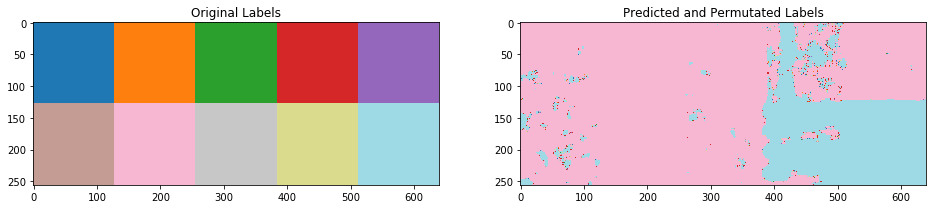

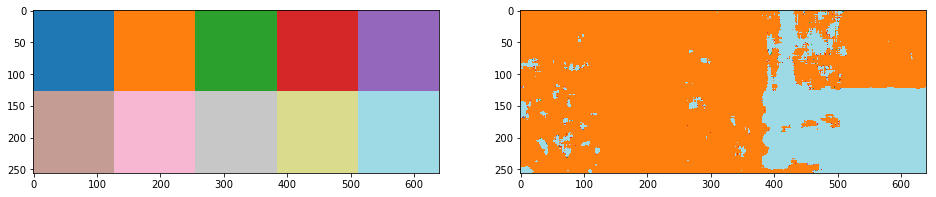

1  --- temperature:  0.27
0  --- EM_counter.
0.06314235219929941
1  --- EM_counter.
0.0050247204502705456
2  --- EM_counter.
0.002173408085876137
3  --- EM_counter.
0.0010950005606666308
4  --- EM_counter.
0.000584836497444648
5  --- EM_counter.
0.0003282596955024413
6  --- EM_counter.
0.00019762537108072847
7  --- EM_counter.
0.00013453313705203687
8  --- EM_counter.
0.00010827493962396788
9  --- EM_counter.
0.00010009996370848333
10  --- EM_counter.
9.947939564584245e-05


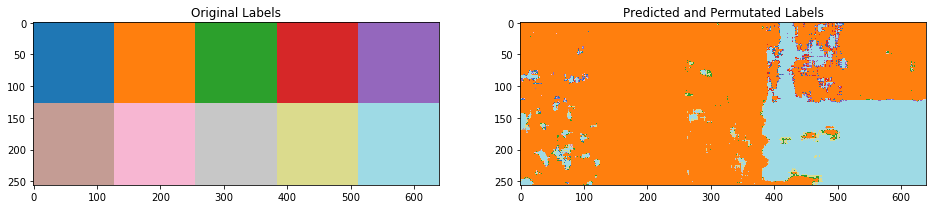

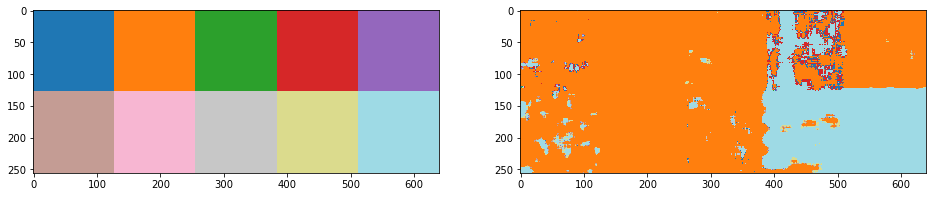

2  --- temperature:  0.24300000000000002
0  --- EM_counter.
0.057106671853490325
1  --- EM_counter.
0.0040417593321029725
2  --- EM_counter.
0.0019546157413295557
3  --- EM_counter.
0.0014724895574436475
4  --- EM_counter.
0.001428742922139203
5  --- EM_counter.
0.0015595922198339508
6  --- EM_counter.
0.0017845808428699056
7  --- EM_counter.
0.00209612464267444
8  --- EM_counter.
0.0025224085493392593
9  --- EM_counter.
0.003126238143002287
10  --- EM_counter.
0.004026347816295567
11  --- EM_counter.
0.005446482452340627
12  --- EM_counter.
0.007808450725080588
13  --- EM_counter.
0.011858850608271326
14  --- EM_counter.
0.01855252031373612
15  --- EM_counter.
0.02742454073273907
16  --- EM_counter.
0.03293354797815867
17  --- EM_counter.
0.02885156534000297
18  --- EM_counter.
0.019074637376816295
19  --- EM_counter.
0.009557617144012136
20  --- EM_counter.
0.003696731677611938
21  --- EM_counter.
0.0012818464053991271
22  --- EM_counter.
0.000490526259877961
23  --- EM_counter.
0.00

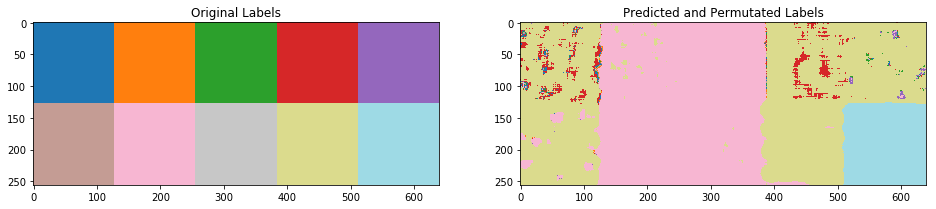

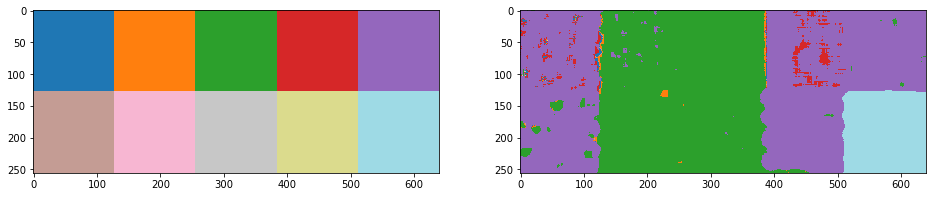

3  --- temperature:  0.21870000000000003
0  --- EM_counter.
0.058518603033428616
1  --- EM_counter.
0.005036817523900121
2  --- EM_counter.
0.002657620126452012
3  --- EM_counter.
0.0017037540749336307
4  --- EM_counter.
0.0011679613434728904
5  --- EM_counter.
0.0008367403919091932
6  --- EM_counter.
0.0006196203481675499
7  --- EM_counter.
0.00047106961028338254
8  --- EM_counter.
0.0003660008269522103
9  --- EM_counter.
0.00028963387281800594
10  --- EM_counter.
0.00023279408181876144
11  --- EM_counter.
0.00018956279872477596
12  --- EM_counter.
0.00015601828064511496
13  --- EM_counter.
0.00012951241878945077
14  --- EM_counter.
0.0001082295568969376
15  --- EM_counter.
9.090577600258264e-05


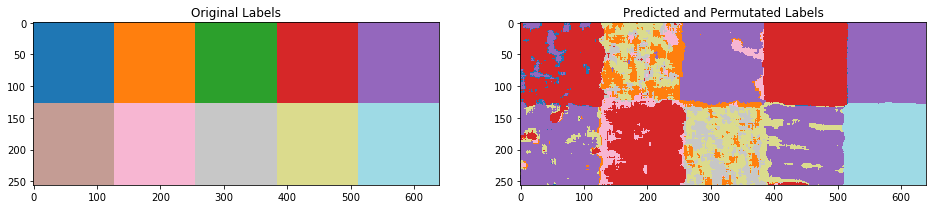

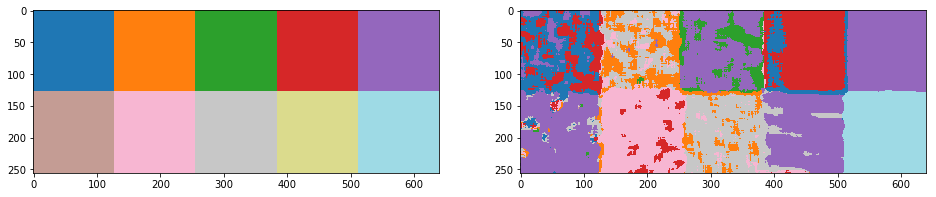

4  --- temperature:  0.19683000000000003
0  --- EM_counter.
0.06118830052943528
1  --- EM_counter.
0.0041261076103914
2  --- EM_counter.
0.0019119998106205158
3  --- EM_counter.
0.0012110597908236746
4  --- EM_counter.
0.0008543451062225639
5  --- EM_counter.
0.0006496853821736207
6  --- EM_counter.
0.0005209587131787288
7  --- EM_counter.
0.00043338243056230115
8  --- EM_counter.
0.0003700497411475822
9  --- EM_counter.
0.0003221957102861643
10  --- EM_counter.
0.0002849220942957021
11  --- EM_counter.
0.0002552632433843656
12  --- EM_counter.
0.00023128172442950058
13  --- EM_counter.
0.0002116287107053384
14  --- EM_counter.
0.00019532020646082396
15  --- EM_counter.
0.00018161630658238435
16  --- EM_counter.
0.0001699510245690071
17  --- EM_counter.
0.00015988784470053068
18  --- EM_counter.
0.00015108912648045418
19  --- EM_counter.
0.00014329364047763275
20  --- EM_counter.
0.00013629940671952827
21  --- EM_counter.
0.00012995033861489132
22  --- EM_counter.
0.0001241257986169116

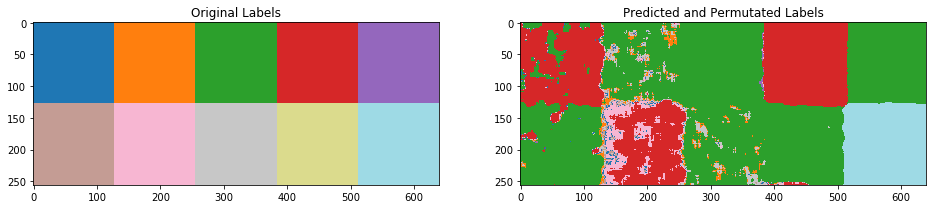

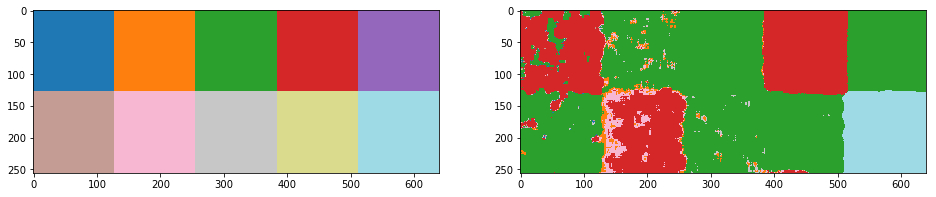

5  --- temperature:  0.17714700000000003
0  --- EM_counter.
0.05959611747670645
1  --- EM_counter.
0.004493784451833094
2  --- EM_counter.
0.002082214858522026
3  --- EM_counter.
0.0014127983510347085
4  --- EM_counter.
0.0011252137339483276
5  --- EM_counter.
0.0010242362663257878
6  --- EM_counter.
0.0010482708833235894
7  --- EM_counter.
0.0011741928857066613
8  --- EM_counter.
0.0014017908155596534
9  --- EM_counter.
0.0017529465878271832
10  --- EM_counter.
0.0022762188066804464
11  --- EM_counter.
0.0030574198958899126
12  --- EM_counter.
0.0042352272189545345
13  --- EM_counter.
0.006006148891659634
14  --- EM_counter.
0.008550182132536917
15  --- EM_counter.
0.011712044854318402
16  --- EM_counter.
0.014463364943186978
17  --- EM_counter.
0.015253621357692121
18  --- EM_counter.
0.013787624553038481
19  --- EM_counter.
0.011091439269427341
20  --- EM_counter.
0.008008151998862765
21  --- EM_counter.
0.005116713488430389
22  --- EM_counter.
0.0029019012819493386
23  --- EM_count

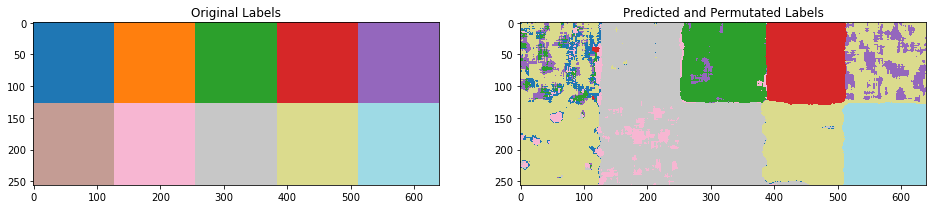

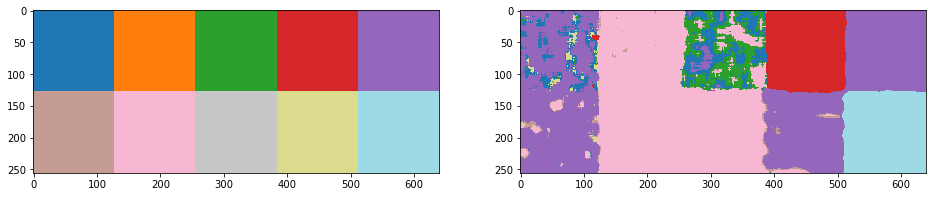

6  --- temperature:  0.15943230000000003
0  --- EM_counter.
0.05575581379742649
1  --- EM_counter.
0.004555158342938123
2  --- EM_counter.
0.0022787208908033826
3  --- EM_counter.
0.0017950471444089242
4  --- EM_counter.
0.0017260391117948973
5  --- EM_counter.
0.0018444786138757207
6  --- EM_counter.
0.00208654754934986
7  --- EM_counter.
0.0024426236493171384
8  --- EM_counter.
0.00293041288532795
9  --- EM_counter.
0.0035877184173909197
10  --- EM_counter.
0.00447078108711447
11  --- EM_counter.
0.005649833034679397
12  --- EM_counter.
0.007189895117419689
13  --- EM_counter.
0.009099787240440842
14  --- EM_counter.
0.011244587603438952
15  --- EM_counter.
0.0132535123772232
16  --- EM_counter.
0.014457546220534903
17  --- EM_counter.
0.01413651344390323
18  --- EM_counter.
0.012475654094674347
19  --- EM_counter.
0.010547816070738004
20  --- EM_counter.
0.008952404608825995
21  --- EM_counter.
0.007825854498261143
22  --- EM_counter.
0.007880519468714717
23  --- EM_counter.
0.00969

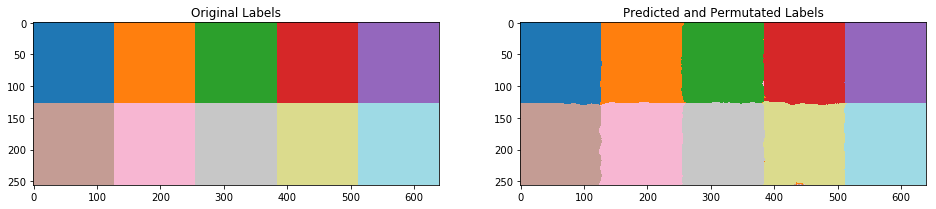

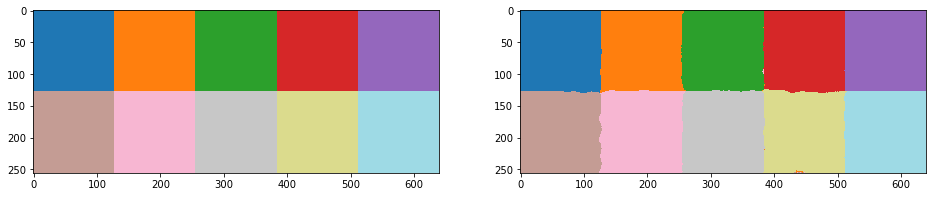

7  --- temperature:  0.14348907000000002
0  --- EM_counter.
0.002519807296708128
1  --- EM_counter.
0.0006731869936303915
2  --- EM_counter.
0.00027459456833146215
3  --- EM_counter.
0.00012305774142025043
4  --- EM_counter.
5.614784879072747e-05


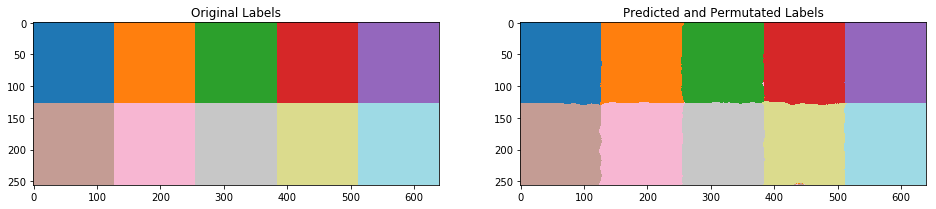

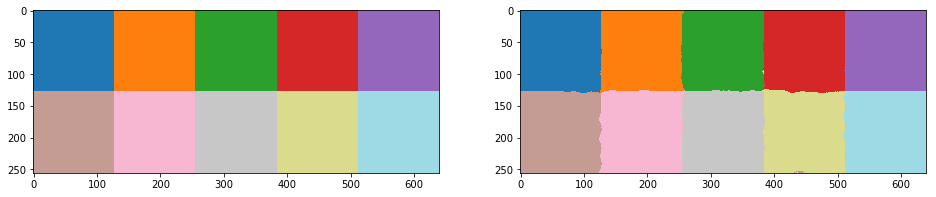

8  --- temperature:  0.12914016300000003
0  --- EM_counter.
0.0015475500507177117
1  --- EM_counter.
0.0003699794224013126
2  --- EM_counter.
0.00014025166708169837
3  --- EM_counter.
5.6360952541170854e-05


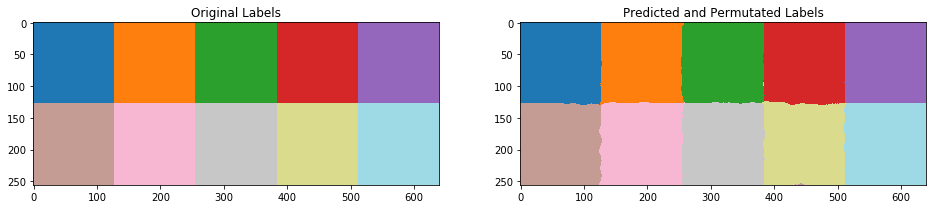

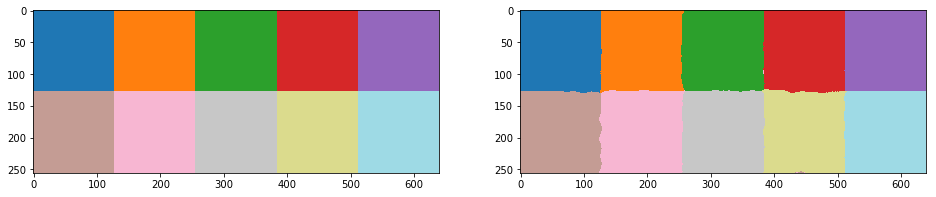

9  --- temperature:  0.11622614670000003
0  --- EM_counter.
0.0009906840404187286
1  --- EM_counter.
0.00022509446663941158
2  --- EM_counter.
7.751231454327123e-05


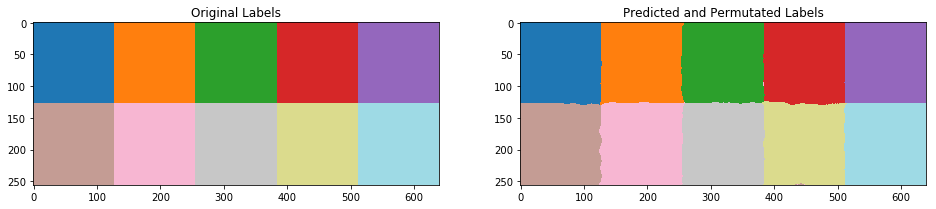

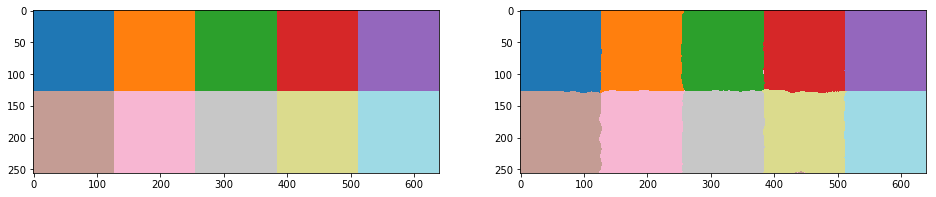

10  --- temperature:  0.10460353203000003
0  --- EM_counter.
0.0006694139714361788
1  --- EM_counter.
0.00014812317788237154
2  --- EM_counter.
4.583794300591511e-05


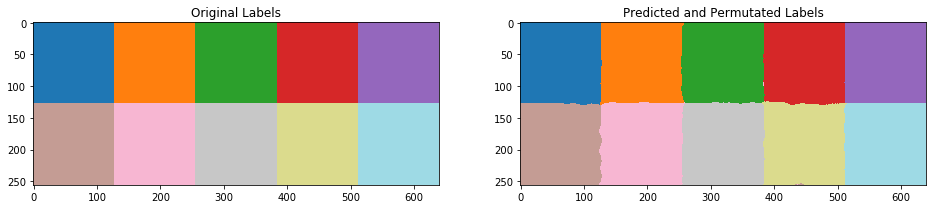

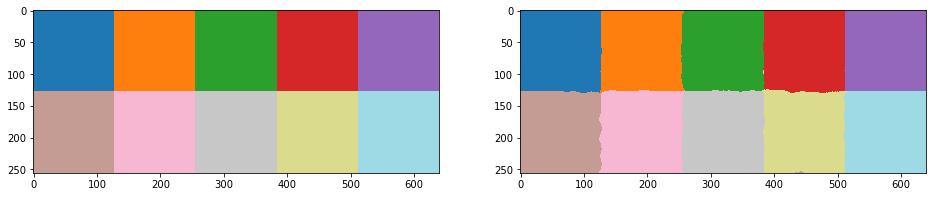

centroids : [[6.75823548e-05 5.93839049e-05 3.21828354e-04 ... 0.00000000e+00
  3.80423543e-04 3.54310462e-04]
 [1.12324800e-06 4.41909014e-07 8.23349380e-07 ... 0.00000000e+00
  1.64754972e-04 3.47444525e-04]
 [2.84665370e-04 7.51831575e-07 2.44854316e-06 ... 0.00000000e+00
  5.60231238e-05 1.71995868e-04]
 ...
 [2.19063802e-04 1.64388943e-04 2.34409446e-04 ... 0.00000000e+00
  2.77784698e-04 4.17100712e-04]
 [1.64767278e-02 2.37707339e-06 4.67103954e-06 ... 0.00000000e+00
  1.16634260e-02 1.83245440e-03]
 [3.42645633e-06 1.34393454e-08 3.72117704e-08 ... 0.00000000e+00
  3.42288467e-07 5.29485940e-07]]
CPU times: user 46min 49s, sys: 19min 31s, total: 1h 6min 20s
Wall time: 1h 14min 6s


In [14]:
%%time
HC = HistogramClustering(estimation="DA")
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

In [21]:
from sklearn.feature_extraction import image
import random


0  --- temperature:  0.3
0  --- EM_counter.
0.06328354994824076
1  --- EM_counter.
0.0045440552220913765
2  --- EM_counter.
0.0017701982228327268
3  --- EM_counter.
0.000873578840262781
4  --- EM_counter.
0.0005184270632607867
5  --- EM_counter.
0.0003742852704660371
6  --- EM_counter.
0.00031180520686755966
7  --- EM_counter.
0.00027886021517086607
8  --- EM_counter.
0.0002566494255373503
9  --- EM_counter.
0.00023883785956760938
10  --- EM_counter.
0.00022325167883599539
11  --- EM_counter.
0.00020907578421492162
12  --- EM_counter.
0.00019595544627831708
13  --- EM_counter.
0.00018370507154530708
14  --- EM_counter.
0.0001722097225513238
15  --- EM_counter.
0.00016138932843156876
16  --- EM_counter.
0.00015118408636766886
17  --- EM_counter.
0.00014154746081422592
18  --- EM_counter.
0.0001324421842094939
19  --- EM_counter.
0.00012383763425597894
20  --- EM_counter.
0.00011570796924389608
21  --- EM_counter.
0.00010803075479596753
22  --- EM_counter.
0.00010078594492586651
23  --- 

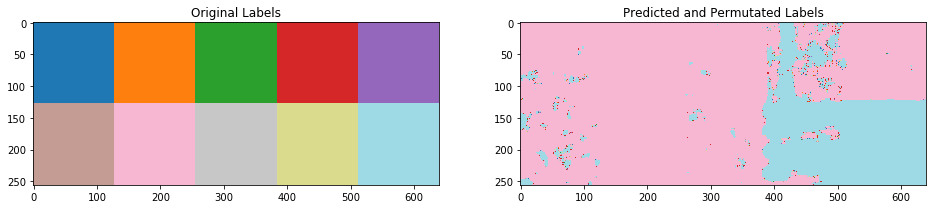

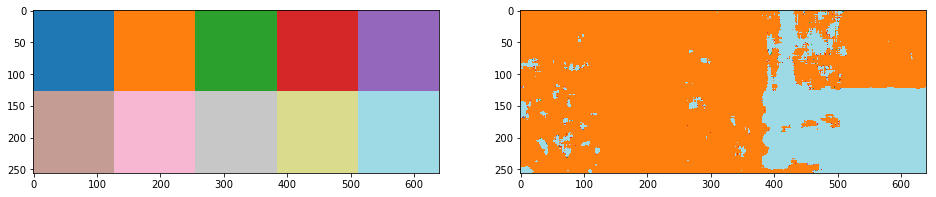

1  --- temperature:  0.27
0  --- EM_counter.
0.06314235219929941
1  --- EM_counter.
0.0050247204502705456
2  --- EM_counter.
0.002173408085876137
3  --- EM_counter.
0.0010950005606666308
4  --- EM_counter.
0.000584836497444648
5  --- EM_counter.
0.0003282596955024413
6  --- EM_counter.
0.00019762537108072847
7  --- EM_counter.
0.00013453313705203687
8  --- EM_counter.
0.00010827493962396788
9  --- EM_counter.
0.00010009996370848333
10  --- EM_counter.
9.947939564584245e-05


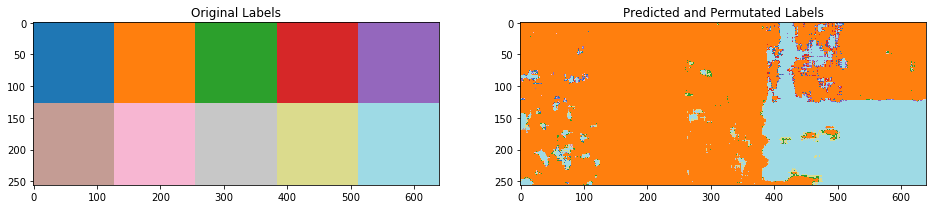

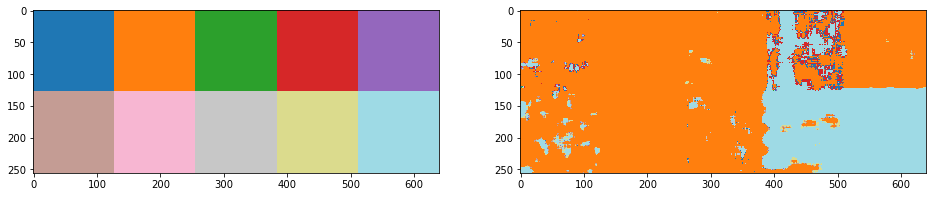

2  --- temperature:  0.24300000000000002
0  --- EM_counter.
0.057106671853490325
1  --- EM_counter.
0.0040417593321029725
2  --- EM_counter.
0.0019546157413295557
3  --- EM_counter.
0.0014724895574436475
4  --- EM_counter.
0.001428742922139203
5  --- EM_counter.
0.0015595922198339508
6  --- EM_counter.
0.0017845808428699056
7  --- EM_counter.
0.00209612464267444
8  --- EM_counter.
0.0025224085493392593
9  --- EM_counter.
0.003126238143002287
10  --- EM_counter.
0.004026347816295567
11  --- EM_counter.
0.005446482452340627
12  --- EM_counter.
0.007808450725080588
13  --- EM_counter.
0.011858850608271326
14  --- EM_counter.
0.01855252031373612
15  --- EM_counter.
0.02742454073273907
16  --- EM_counter.
0.03293354797815867
17  --- EM_counter.
0.02885156534000297
18  --- EM_counter.
0.019074637376816295
19  --- EM_counter.
0.009557617144012136
20  --- EM_counter.
0.003696731677611938
21  --- EM_counter.
0.0012818464053991271
22  --- EM_counter.
0.000490526259877961
23  --- EM_counter.
0.00

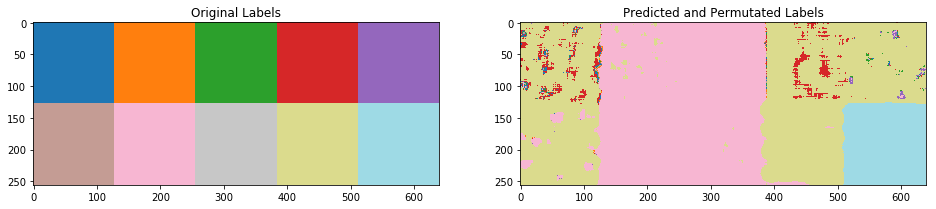

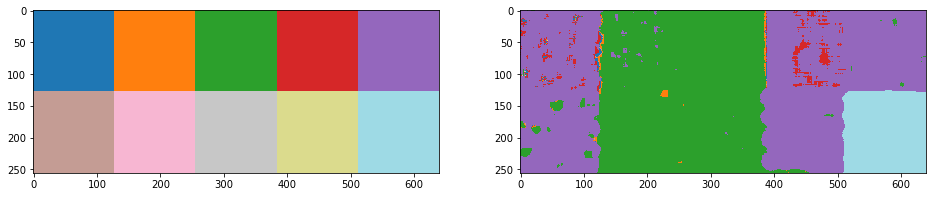

3  --- temperature:  0.21870000000000003
0  --- EM_counter.
0.058518603033428616
1  --- EM_counter.
0.005036817523900121
2  --- EM_counter.
0.002657620126452012
3  --- EM_counter.
0.0017037540749336307
4  --- EM_counter.
0.0011679613434728904
5  --- EM_counter.
0.0008367403919091932
6  --- EM_counter.
0.0006196203481675499
7  --- EM_counter.
0.00047106961028338254
8  --- EM_counter.
0.0003660008269522103
9  --- EM_counter.
0.00028963387281800594
10  --- EM_counter.
0.00023279408181876144
11  --- EM_counter.
0.00018956279872477596
12  --- EM_counter.
0.00015601828064511496
13  --- EM_counter.
0.00012951241878945077
14  --- EM_counter.
0.0001082295568969376
15  --- EM_counter.
9.090577600258264e-05


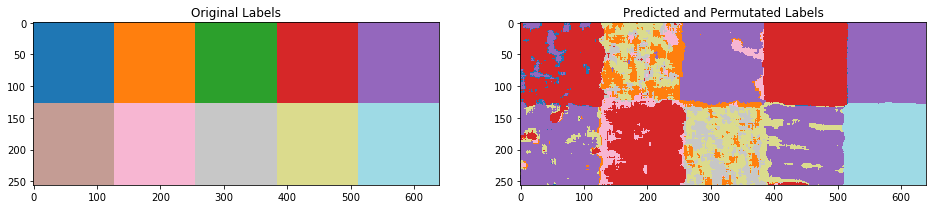

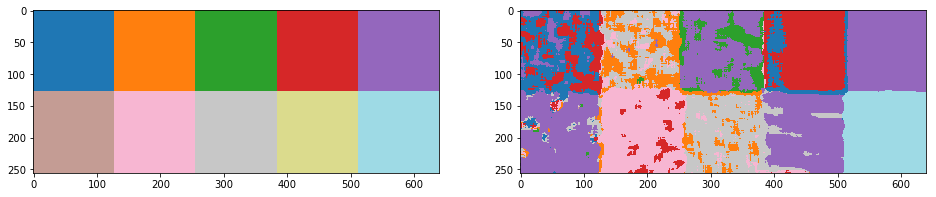

4  --- temperature:  0.19683000000000003
0  --- EM_counter.
0.06118830052943528
1  --- EM_counter.
0.0041261076103914
2  --- EM_counter.
0.0019119998106205158
3  --- EM_counter.
0.0012110597908236746
4  --- EM_counter.
0.0008543451062225639
5  --- EM_counter.
0.0006496853821736207
6  --- EM_counter.
0.0005209587131787288
7  --- EM_counter.
0.00043338243056230115
8  --- EM_counter.
0.0003700497411475822
9  --- EM_counter.
0.0003221957102861643
10  --- EM_counter.
0.0002849220942957021
11  --- EM_counter.
0.0002552632433843656
12  --- EM_counter.
0.00023128172442950058
13  --- EM_counter.
0.0002116287107053384
14  --- EM_counter.
0.00019532020646082396
15  --- EM_counter.
0.00018161630658238435
16  --- EM_counter.
0.0001699510245690071
17  --- EM_counter.
0.00015988784470053068
18  --- EM_counter.
0.00015108912648045418
19  --- EM_counter.
0.00014329364047763275
20  --- EM_counter.
0.00013629940671952827
21  --- EM_counter.
0.00012995033861489132
22  --- EM_counter.
0.0001241257986169116

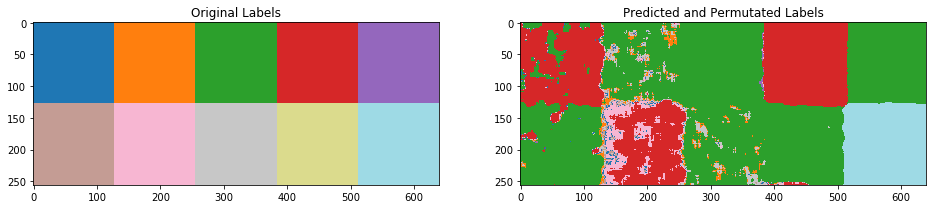

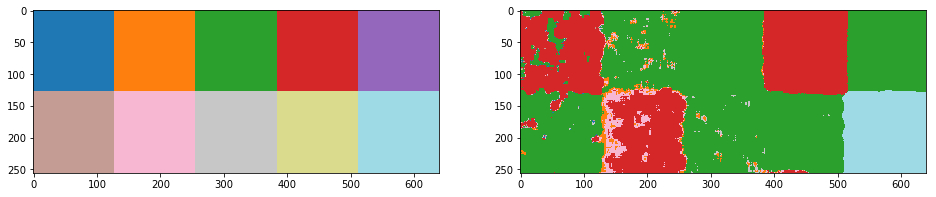

5  --- temperature:  0.17714700000000003
0  --- EM_counter.
0.05959611747670645
1  --- EM_counter.
0.004493784451833094
2  --- EM_counter.
0.002082214858522026
3  --- EM_counter.
0.0014127983510347085
4  --- EM_counter.
0.0011252137339483276
5  --- EM_counter.
0.0010242362663257878
6  --- EM_counter.
0.0010482708833235894
7  --- EM_counter.
0.0011741928857066613
8  --- EM_counter.
0.0014017908155596534
9  --- EM_counter.
0.0017529465878271832
10  --- EM_counter.
0.0022762188066804464
11  --- EM_counter.
0.0030574198958899126
12  --- EM_counter.
0.0042352272189545345
13  --- EM_counter.
0.006006148891659634
14  --- EM_counter.
0.008550182132536917
15  --- EM_counter.
0.011712044854318402
16  --- EM_counter.
0.014463364943186978
17  --- EM_counter.
0.015253621357692121
18  --- EM_counter.
0.013787624553038481
19  --- EM_counter.
0.011091439269427341
20  --- EM_counter.
0.008008151998862765
21  --- EM_counter.
0.005116713488430389
22  --- EM_counter.
0.0029019012819493386
23  --- EM_count

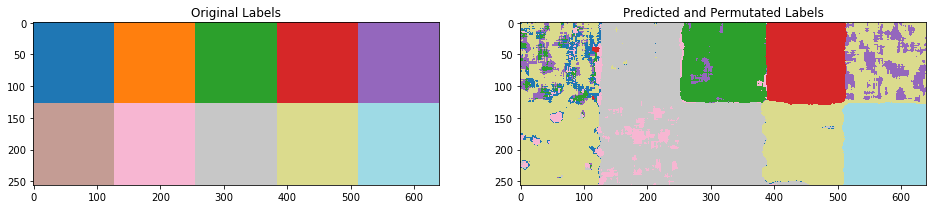

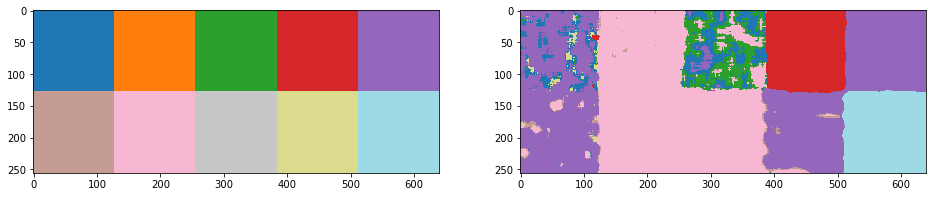

6  --- temperature:  0.15943230000000003
0  --- EM_counter.
0.05575581379742649
1  --- EM_counter.
0.004555158342938123
2  --- EM_counter.
0.0022787208908033826
3  --- EM_counter.
0.0017950471444089242
4  --- EM_counter.
0.0017260391117948973
5  --- EM_counter.
0.0018444786138757207
6  --- EM_counter.
0.00208654754934986
7  --- EM_counter.
0.0024426236493171384
8  --- EM_counter.
0.00293041288532795
9  --- EM_counter.
0.0035877184173909197
10  --- EM_counter.
0.00447078108711447
11  --- EM_counter.
0.005649833034679397
12  --- EM_counter.
0.007189895117419689
13  --- EM_counter.
0.009099787240440842
14  --- EM_counter.
0.011244587603438952
15  --- EM_counter.
0.0132535123772232
16  --- EM_counter.
0.014457546220534903
17  --- EM_counter.
0.01413651344390323
18  --- EM_counter.
0.012475654094674347
19  --- EM_counter.
0.010547816070738004
20  --- EM_counter.
0.008952404608825995
21  --- EM_counter.
0.007825854498261143
22  --- EM_counter.
0.007880519468714717
23  --- EM_counter.
0.00969

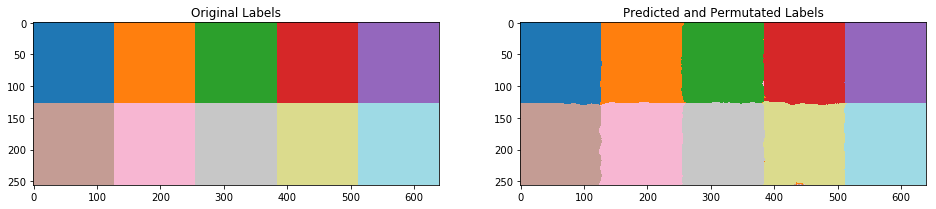

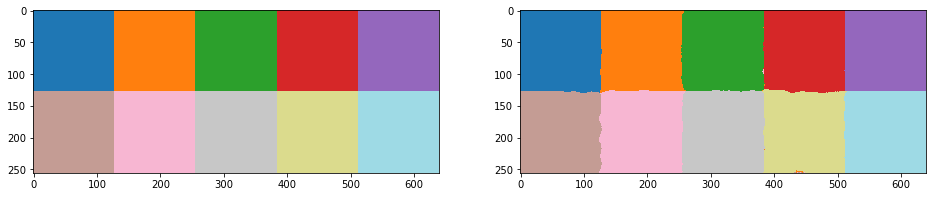

7  --- temperature:  0.14348907000000002
0  --- EM_counter.
0.002519807296708128
1  --- EM_counter.
0.0006731869936303915
2  --- EM_counter.
0.00027459456833146215
3  --- EM_counter.
0.00012305774142025043
4  --- EM_counter.
5.614784879072747e-05


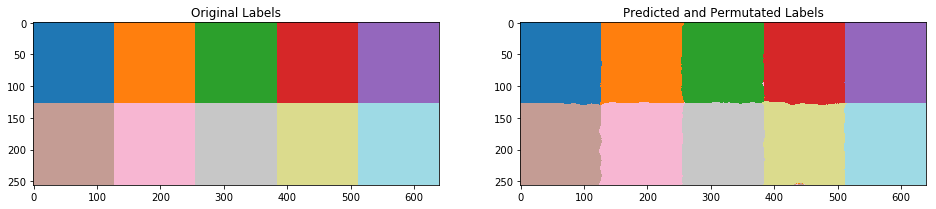

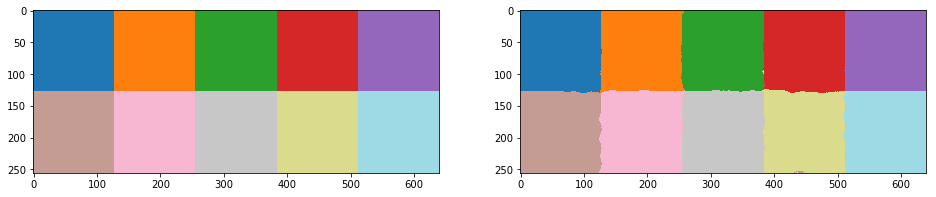

8  --- temperature:  0.12914016300000003
0  --- EM_counter.
0.0015475500507177117
1  --- EM_counter.
0.0003699794224013126
2  --- EM_counter.
0.00014025166708169837
3  --- EM_counter.
5.6360952541170854e-05


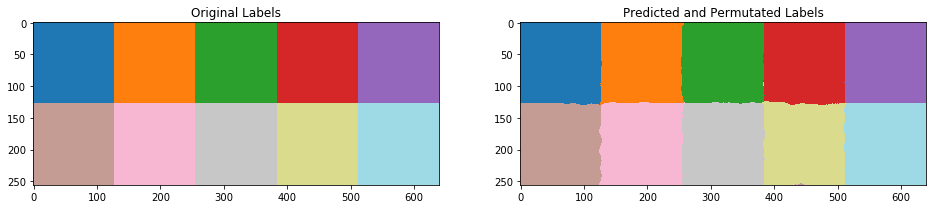

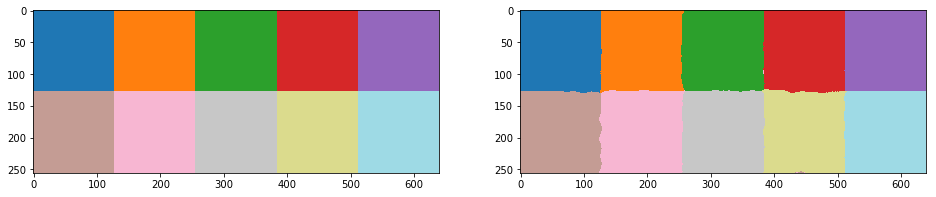

9  --- temperature:  0.11622614670000003
0  --- EM_counter.
0.0009906840404187286
1  --- EM_counter.
0.00022509446663941158
2  --- EM_counter.
7.751231454327123e-05


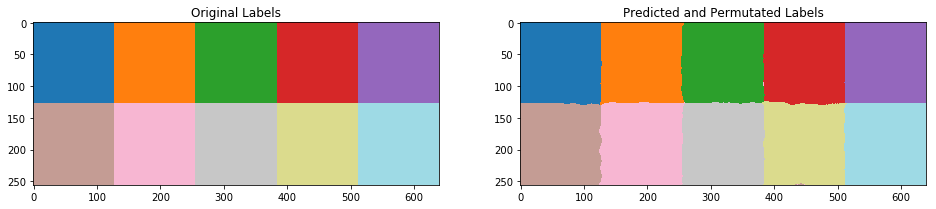

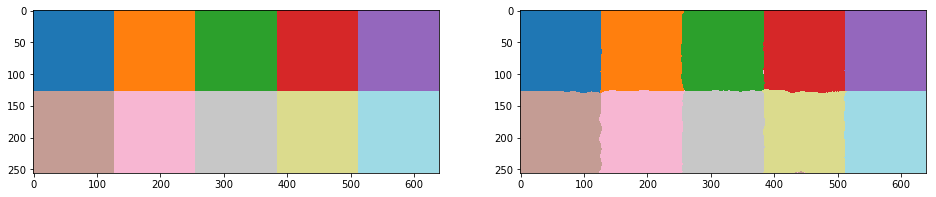

10  --- temperature:  0.10460353203000003
0  --- EM_counter.
0.0006694139714361788
1  --- EM_counter.
0.00014812317788237154
2  --- EM_counter.
4.583794300591511e-05


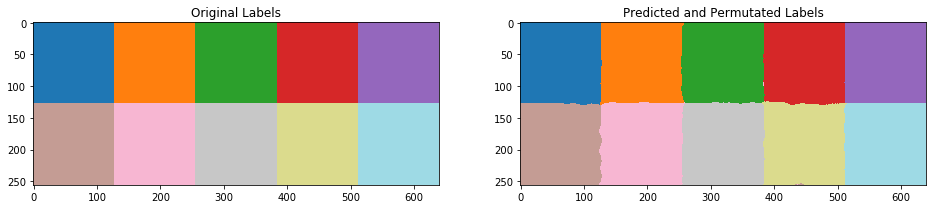

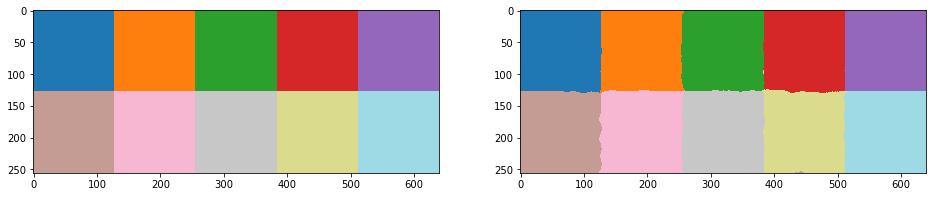

centroids : [[6.75823548e-05 5.93839049e-05 3.21828354e-04 ... 0.00000000e+00
  3.80423543e-04 3.54310462e-04]
 [1.12324800e-06 4.41909014e-07 8.23349380e-07 ... 0.00000000e+00
  1.64754972e-04 3.47444525e-04]
 [2.84665370e-04 7.51831575e-07 2.44854316e-06 ... 0.00000000e+00
  5.60231238e-05 1.71995868e-04]
 ...
 [2.19063802e-04 1.64388943e-04 2.34409446e-04 ... 0.00000000e+00
  2.77784698e-04 4.17100712e-04]
 [1.64767278e-02 2.37707339e-06 4.67103954e-06 ... 0.00000000e+00
  1.16634260e-02 1.83245440e-03]
 [3.42645633e-06 1.34393454e-08 3.72117704e-08 ... 0.00000000e+00
  3.42288467e-07 5.29485940e-07]]
CPU times: user 52min 20s, sys: 28min 56s, total: 1h 21min 16s
Wall time: 1h 54min 15s


In [13]:
%%time
HC = HistogramClustering(estimation="DA")
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

In [23]:
%%time
pred_label_map = HC.predict(texture)

CPU times: user 40.5 s, sys: 3.82 s, total: 44.3 s
Wall time: 50.7 s


/Users/tjpeter/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:319: RuntimeWarning: invalid value encountered in true_divide


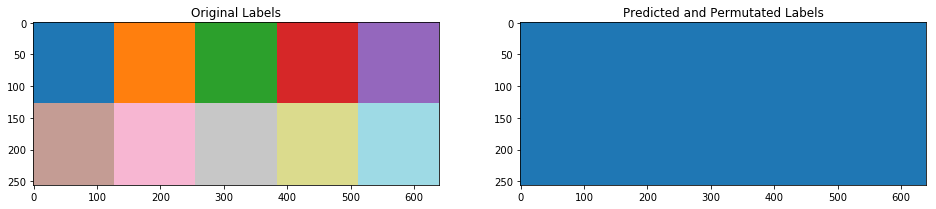

In [24]:
perm_plot(label_map, pred_label_map)

In [ ]:
  # hists = hists.reshape(-1, hists.shape[-1]) 
                    # hists = hists / np.sum(hists, axis = 1)
                    hists = np.divide(hists,  np.sum(hists, axis = 2))

In [95]:
%%time
import random
from sklearn.feature_extraction import image

HC_2 = HistogramClustering_2(estimation="DA")
HC_2.fit(texture)
check_is_fitted(HC_2, ["centroids"])

init:  (128,)
self.centroids 1:  (10, 128)
self.centroids 2:  (10, 128)
p:  (163840, 10)
T = 0.3
--- 0 shape (10, 128) ------
> <ipython-input-92-f4c709350ec7>(204)fit_DA()
    202                 set_trace()
    203                 # Vectorised version:
--> 204                 kls = np.array([-np.sum(np.multiply(hists, np.log(np.divide(hists, k + 10e-4) + 10e-10)), axis=1) / T 
    205                        for k in self.centroids])
    206                 #kls = kls - np.max(kls, axis=0)

ipdb> quit


BdbQuit: 

In [12]:
import random
from sklearn.feature_extraction import image

def match_maps(refmap, mymap, n_clusters):
    org_shape = mymap.shape
    refmap = np.reshape(refmap, (-1,))
    mymap = np.reshape(mymap, (-1,))
    ids = {}    
    new_map = {}
    commons_mat = np.zeros((n_clusters, n_clusters), dtype=int)
    for c in range(0, n_clusters):
        myid = np.where(mymap == c)[0]
        ids[c] = myid
        commons = [np.intersect1d(myid, np.where(refmap == i)[0]).size for i in range(0, n_clusters)]
        commons_mat[c,:] = commons
    for c in range(0, n_clusters):
        max_match = np.unravel_index(commons_mat.argmax(), commons_mat.shape)
        new_map[max_match[0]] = max_match[1]
        commons_mat[max_match[0],:] = -1
        commons_mat[:,max_match[1]] = -1
    copymap = mymap.copy()
    for c in range(0, n_clusters):
        copymap[ids[c]] = new_map[c]
    return np.reshape(copymap, org_shape), new_map

In [11]:
def get_patches(X, window_size=13):
    ws = window_size
    " patches.shape: (n_pixels, self.window_size, self.window_size) "
    paddim = int(ws/2 - 0.5)
    padmat = ((paddim,paddim),(paddim,paddim))
    padded = np.lib.pad(X, padmat, 'constant', constant_values=((-1, -1),(-1, -1)))
    patches = image.extract_patches_2d(padded, (ws, ws))
    return patches

In [12]:
get_patches(texture).shape

(163840, 13, 13)

In [ ]:
        # Calculate histograms
        if hists is None:
            patches = self.get_patches(X)
            hists = np.apply_along_axis(self.get_hist, 1, np.reshape(patches, (n_pixels, -1)), True)
        self.train_hists = hists

        # Initialize centroids
        init_center = np.mean(hists, axis=0)
        self.centroids = np.repeat(init_center[np.newaxis,:], self.n_clusters, axis=0)
        self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])

<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

In [22]:
%%time
HC_MAP = HistogramClustering()
HC_MAP.fit(texture)
check_is_fitted(HC_MAP, ["centroids"])

CPU times: user 1min 12s, sys: 5.52 s, total: 1min 17s
Wall time: 1min 18s


In [23]:
%%time
pred_label_map = HC_MAP.predict(texture)

CPU times: user 37.4 s, sys: 1.21 s, total: 38.6 s
Wall time: 50.9 s


<ul style="background-color:#F9E9C6;"> 
Note that we need to permutate the labels of the prediction to be in line with the original ones.
The following displays the original labels and predicted and permuated ones.
<u1/>

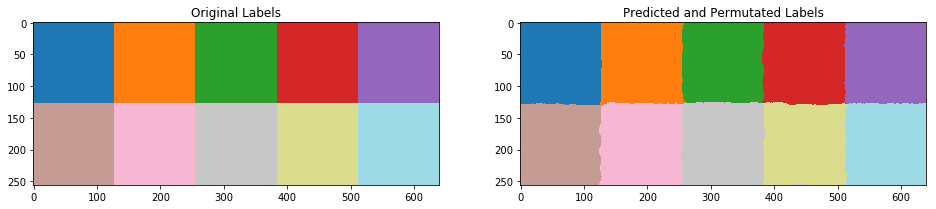

In [24]:
perm_plot(label_map, pred_label_map)

patch  0
0 0
patch  1
0 1
patch  2
0 2
patch  3
0 3
patch  4
0 4
patch  5
1 0
patch  6
1 1
patch  7
1 2
patch  8
1 3
patch  9
1 4


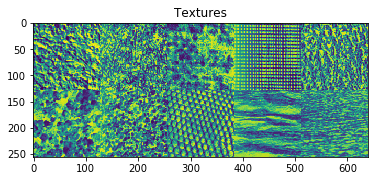

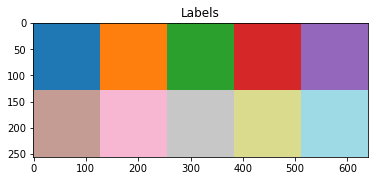

In [28]:
texture = imread("texture.png")

C1 = np.ones(patch_shape) * 0
X1 = HC_MAP.generate(C1)

label_map = np.ones(texture.shape)

for patch in range(np.prod(patch_grid_shape)):
    print('patch ',patch)
    i, j = np.unravel_index(patch, patch_grid_shape)
    print(i,j)
    label_map[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)] = np.ravel_multi_index((i, j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

In [29]:
%%time
HC = HistogramClustering(window_size=15)
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

KeyboardInterrupt: 

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

In [30]:
%%time
predicted_perm_label_map = HC_MAP.predict(perm_texture)

CPU times: user 35.6 s, sys: 847 ms, total: 36.4 s
Wall time: 43.7 s


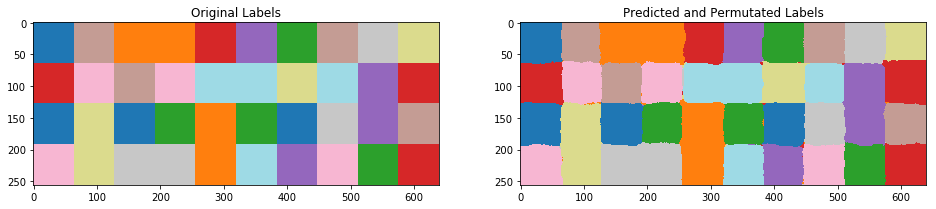

In [31]:
perm_plot(perm_label_map,predicted_perm_label_map)

<p style="background-color:#adebad;">
    Plot the confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, to make them correspond to the true labels (see Hungarian algortihm to find the best match).
</p>

In [16]:
# Confusion matrix
# permute labels

In [17]:
conf_mat = confusion_matrix(np.ravel(perm_label_map), np.ravel(predicted_perm_label_map))
conf_mat_perm = best_perm(conf_mat)
conf_mat_perm

array([[16294,     4,     4,    37,     8,    11,     0,    11,    15,
            0],
       [    0, 16357,     0,     0,     0,     8,    19,     0,     0,
            0],
       [   86,   193, 15772,    22,    85,    63,    13,   120,    18,
           12],
       [  114,   218,    10, 16005,     2,    31,     0,     0,     1,
            3],
       [   99,    12,   110,   117, 15795,    45,   102,   100,     4,
            0],
       [  135,   203,     0,    85,     5, 15802,   148,     6,     0,
            0],
       [   84,    94,   101,   176,     0,    16, 15804,    78,    31,
            0],
       [  115,    75,     0,    14,    29,    34,    17, 16093,     7,
            0],
       [   98,    31,    22,   276,     0,     0,   101,    86, 15770,
            0],
       [    1,   158,    26,   110,   161,    53,     7,   136,   305,
        15427]])

<ul style="background-color:#F9E9C6;"> 
To plot the heatmap of the confusion matrix (before and after permutation), we used the heatmap-function from the seaborn-module.
    
Uncommenting and running the following code , will install the seaborn module in the current conda environment
<u1/>

In [19]:
import sys
!conda install --yes --prefix {sys.prefix} seaborn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [21]:
import seaborn as sns

<ul style="background-color:#F9E9C6;"> 
The following displays first the confusion matrix with the unmatched predictions. The second confusion matrix is obtained by permutating the predicted labels, confirming also the validility of the matching function.
<u1/>

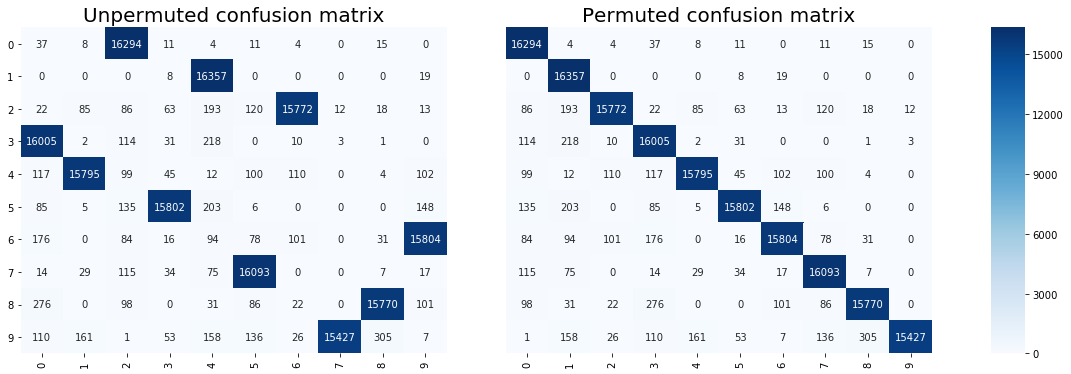

In [22]:
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
            gridspec_kw={'width_ratios':[1,1,0.08]}, figsize=(18, 6))
ax1.get_shared_y_axes().join(ax2)

g1 = sns.heatmap(conf_mat, cmap='Blues', annot=True, cbar=False, fmt='', ax=ax1) 
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_title('Unpermuted confusion matrix', fontsize=20)

g2 = sns.heatmap(conf_mat_perm, cmap='Blues', annot=True, cbar_ax=axcb, fmt='', ax=ax2) 
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g2.set_title('Permuted confusion matrix', fontsize=20)

for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.show()

<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

In [25]:
import os
from time import sleep
from IPython.display import clear_output, display

Currently at n_bin: 64, window_size: 11


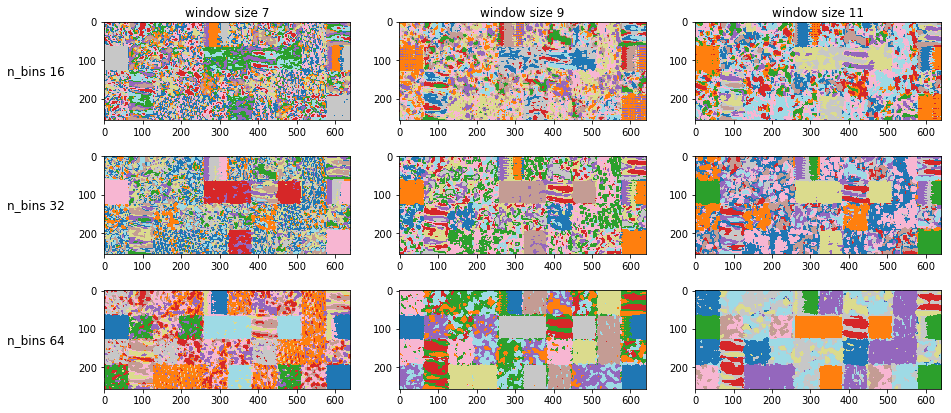

In [26]:
MAX_IT = 100

n_bins = [16, 32, 64]
window_sizes = [7, 9, 11]

acc_matrix = pd.DataFrame(0, index=n_bins, columns=window_sizes)

cols = ['window size {}'.format(col) for col in window_sizes]
rows = ['n_bins {}'.format(row) for row in n_bins]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7))
pad = 5 # in points


for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
for i, n_bin in enumerate(n_bins):
    for j, wind_size in enumerate(window_sizes):
        
        clear_output(wait=True)
        print('Currently at n_bin: {}, window_size: {}'.format(n_bin, wind_size))
        sleep(0.1)
        
        HC0 = HistogramClustering(n_bins=n_bin, window_size=wind_size, max_it=MAX_IT)
        HC0.fit(texture)
        predicted_perm_label_map = HC0.predict(perm_texture)
        
        conf_mat = confusion_matrix(np.ravel(perm_label_map), np.ravel(predicted_perm_label_map))
        perm_conf_mat = best_perm(conf_mat)
        
        # calculate accuracy based on permuted confusion matrix
        accuracy = np.trace(perm_conf_mat)/np.sum(perm_conf_mat)
        acc_matrix.iloc[i,j] = accuracy

        axes[i,j].imshow(predicted_perm_label_map, cmap="tab20")

plt.show()

# 3x3 Matrix with accuracy scores of the different parameter combination

In [27]:
display(acc_matrix.style.highlight_max(color = 'lightgreen', axis=None))

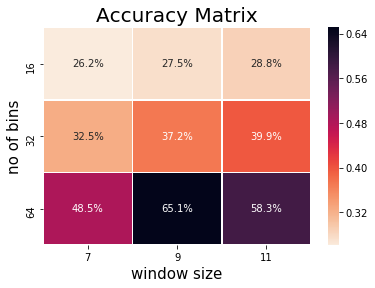

In [28]:
cmap = sns.cm.rocket_r
ax = sns.heatmap(acc_matrix, linewidths=.5, annot=True,  fmt='0.1%', cmap=cmap)
ax.set_title('Accuracy Matrix', fontsize = 20)
plt.xlabel('window size', fontsize = 15)
plt.ylabel('no of bins', fontsize = 15)
plt.show()

<ul style="background-color:#F9E9C6;"> 

  
COMMENT
    
    
<u1/>

<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them accordingly.
    </p>

In [ ]:
# Cluster predictions (9 plots arranged in a 3x3 grid)

<ul style="background-color:#F9E9C6;"> 
Plotting the cluster prediction was already performed with the previous task,
<u1/>

In [ ]:
for i,j in product(range(patch_grid_shape[0]), range(patch_grid_shape[1])): 
    
    
    
acc_matrix = pd.DataFrame(0, index=n_bins, columns=window_sizes)

cols = ['window size {}'.format(col) for col in window_sizes]
rows = ['n_bins {}'.format(row) for row in n_bins]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7))
pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
for i, n_bin in enumerate(n_bins):
    for j, wind_size in enumerate(window_sizes):
        
        clear_output(wait=True)
        print('Currently at n_bin: {}, window_size: {}'.format(n_bin, wind_size))
        sleep(0.1)
        
        HC = HistogramClustering(n_bins=n_bin, window_size=wind_size, max_it=MAX_IT)
        HC.fit(texture)
        predicted_perm_label_map = HC.predict(perm_texture)
        
        conf_mat = confusion_matrix(np.ravel(perm_label_map), np.ravel(predicted_perm_label_map))
        perm_conf_mat = best_perm(conf_mat)
        
        # calculate accuracy based on permuted confusion matrix
        accuracy = np.trace(perm_conf_mat)/np.sum(perm_conf_mat)
        acc_matrix.iloc[i,j] = accuracy

        axes[i,j].imshow(predicted_perm_label_map, cmap="tab20")

plt.show()
    

/Users/tjpeter/anaconda3/envs/slt-ce/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


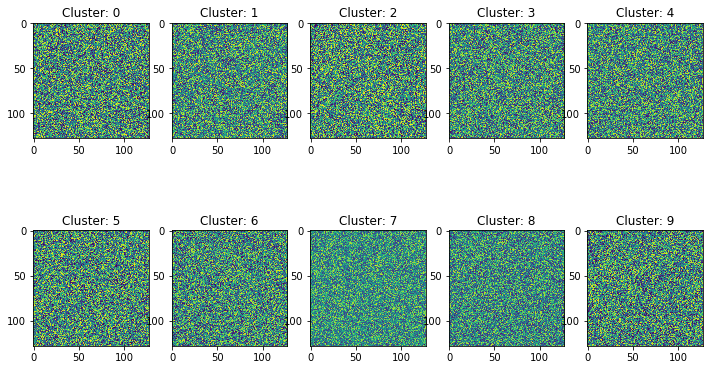

In [23]:
fig, ax = plt.subplots(patch_grid_shape[0], patch_grid_shape[1], figsize=(12, 7))

for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    C = patch* np.ones(patch_shape)
    X = HC.generate(C)
    ax[i, j].imshow(X)
    ax[i, j].set_title('Cluster: '+ str(patch))
    
fig.show()

<h2 style="background-color:#f0b375;">
Section 5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate</b> method for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the generated textures next to the ground truth textures.
        </li>
    </ul>

In [29]:
HC0 = HistogramClustering(n_bins=32)
HC0.fit(texture)

HistogramClustering(estimation='MAP', max_it=100, n_bins=32, n_clusters=10,
          plot_fit=False, random_state=42, window_size=15)

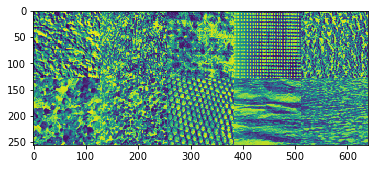

In [31]:
plt.imshow(texture)

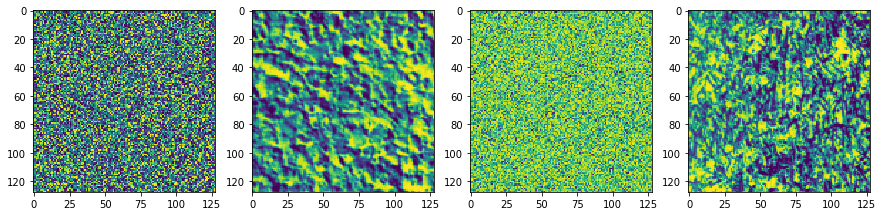

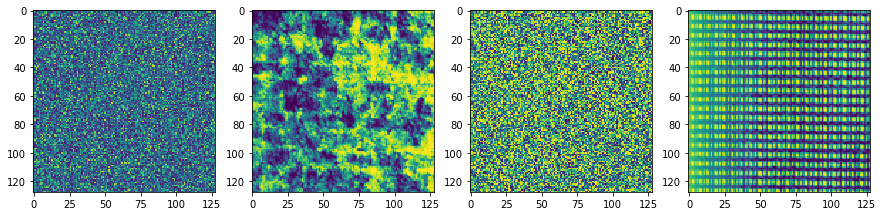

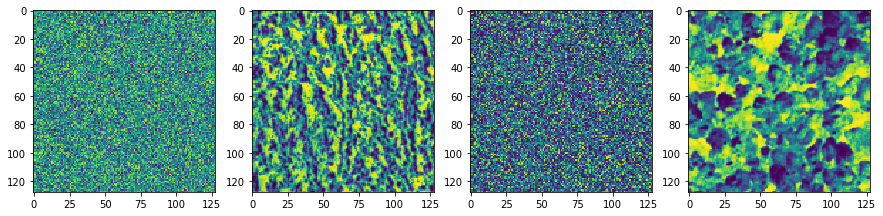

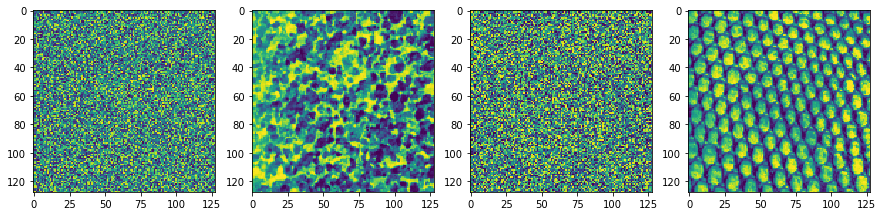

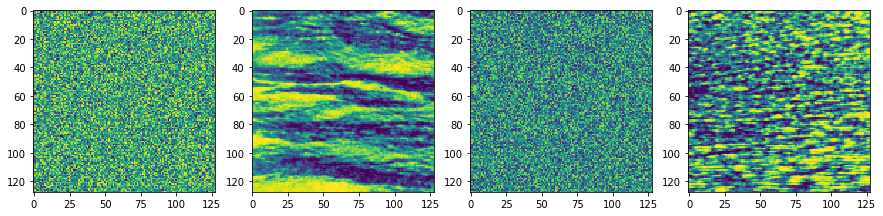

In [32]:
orgs = []
gens= []

for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    org_patch = texture[patch_shape[0] * i : patch_shape[0] * (i + 1), \
              patch_shape[1] * j : patch_shape[1] * (j + 1)]

    C = np.ones(patch_shape, dtype=int) * patch
    gen_patch = HC0.generate(C)
    
    orgs.append(org_patch)
    gens.append(gen_patch)

for i in range(0, len(orgs), 2):
    plt.figure(figsize=(15,15))
    plt.subplot(141)
    plt.imshow(gens[i])
    plt.subplot(142)
    plt.imshow(orgs[i])
    plt.subplot(143)
    plt.imshow(gens[i+1])
    plt.subplot(144)
    plt.imshow(orgs[i+1])
    plt.show()

In [ ]:
C1 = np.ones(patch_shape) * 0
X1 = HC.generate(C1)

# C2, C3, etc. You can also use a more suitable data structure to loop over the textures.

# Generated texture plot

In [ ]:
texture = imread("texture.png")

C1 = np.ones(patch_shape) * 0
X1 = HC.generate(C1)

patch_grid_shape = (2, 5)
patch_shape = (128, 128)
label_map = np.ones(texture.shape)

for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)] = np.ravel_multi_index((i, j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

In [32]:
HC0 = HistogramClustering()
HC0.fit(texture)

HistogramClustering(estimation='MAP', max_it=100, n_bins=128, n_clusters=10,
          plot_fit=False, random_state=42, window_size=15)

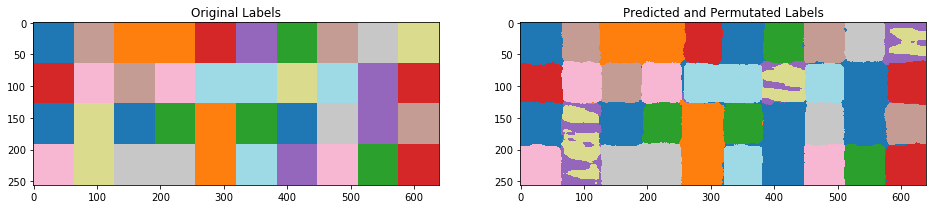

In [33]:
predicted_perm_label_map_HC = HC0.predict(perm_texture)
perm_plot(perm_label_map, predicted_perm_label_map_HC)

In [34]:
train = HC0.feats_fit.reshape(-1,HC0.feats_fit.shape[2])
test = HC0.feats_pred.reshape(-1,HC0.feats_pred.shape[2])

In [35]:
test.shape

(163840, 128)

In [53]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [54]:
km_pred = kmeans.predict(test)

In [57]:
km_pred = km_pred.reshape(perm_label_map.shape)

In [58]:
km_pred

array([[8, 8, 8, ..., 7, 7, 7],
       [8, 8, 8, ..., 7, 7, 7],
       [8, 8, 8, ..., 7, 7, 7],
       ...,
       [1, 1, 1, ..., 5, 5, 5],
       [1, 1, 1, ..., 5, 8, 8],
       [1, 1, 1, ..., 8, 8, 8]], dtype=int32)

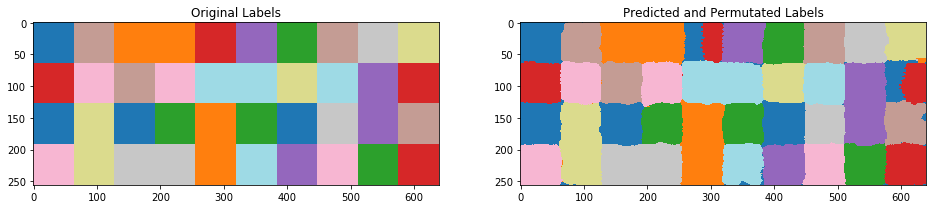

In [60]:
perm_plot(perm_label_map, km_pred)

<ul style="background-color:#adebad;">
    <li>
        Plot and compare the confusion matrices for both, k-means, and HC.
    </li>
</ul>

In [ ]:
# Confusion matrices

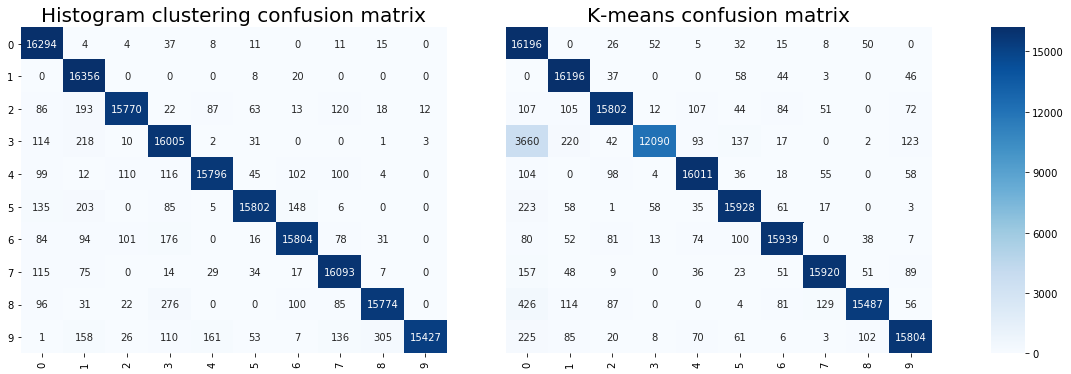

In [62]:
conf_mat_HC = confusion_matrix(np.ravel(perm_label_map), np.ravel(predicted_perm_label_map_HC))
conf_mat_HC = best_perm(conf_mat_HC)

conf_mat_km = confusion_matrix(np.ravel(perm_label_map), np.ravel(km_pred))
conf_mat_km = best_perm(conf_mat_km)


f,(ax1,ax2, axcb) = plt.subplots(1,3, 
            gridspec_kw={'width_ratios':[1,1,0.08]}, figsize=(18, 6))
ax1.get_shared_y_axes().join(ax2)



g1 = sns.heatmap(conf_mat_HC, cmap='Blues', annot=True, cbar=False, fmt='', ax=ax1) 
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_title('Histogram clustering confusion matrix', fontsize=20)

g2 = sns.heatmap(conf_mat_km, cmap='Blues', annot=True, cbar_ax=axcb, fmt='', ax=ax2) 
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g2.set_title('K-means confusion matrix', fontsize=20)

for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.show()

In [64]:
np.trace(conf_mat_HC)/np.sum(conf_mat_HC)


0.971197509765625

In [65]:
np.trace(conf_mat_km)/np.sum(conf_mat_km)

0.948321533203125

<ul style="background-color:#adebad;">
        <li>
Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image, one centroid histogram for every texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

In [ ]:
# Histograms

In [63]:
km_rev = {}
for key, item in km_map.items():
    km_rev[item] = key
hc_rev = {}
for key, item in hc_map.items():
    hc_rev[item] = key

NameError: name 'km_map' is not defined

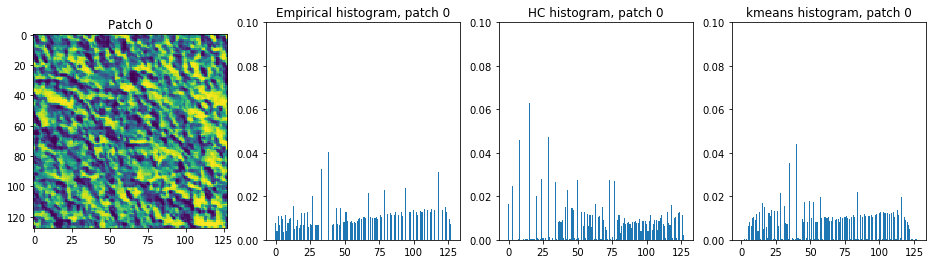

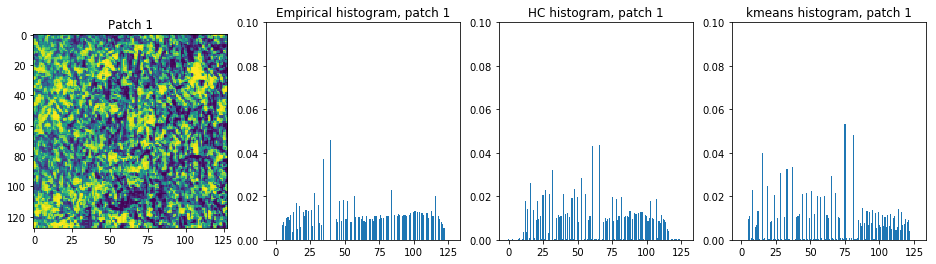

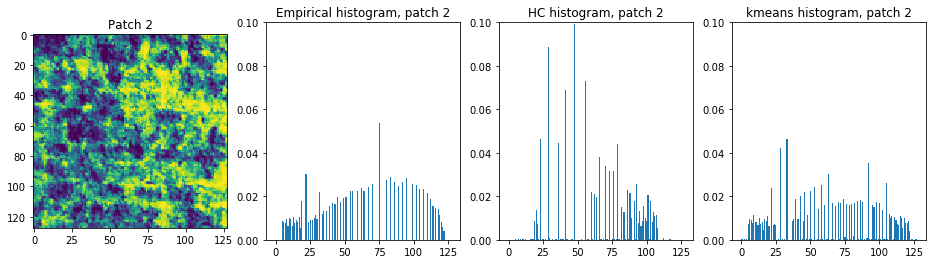

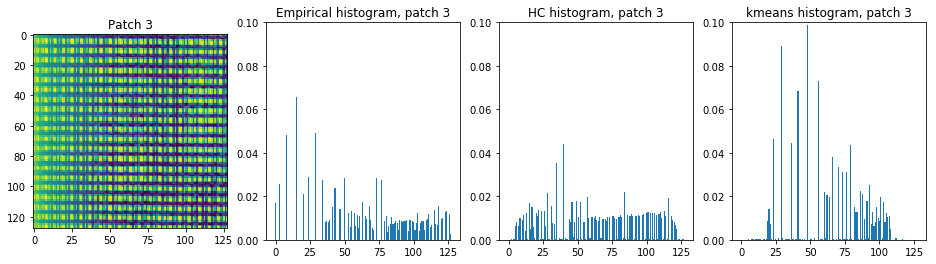

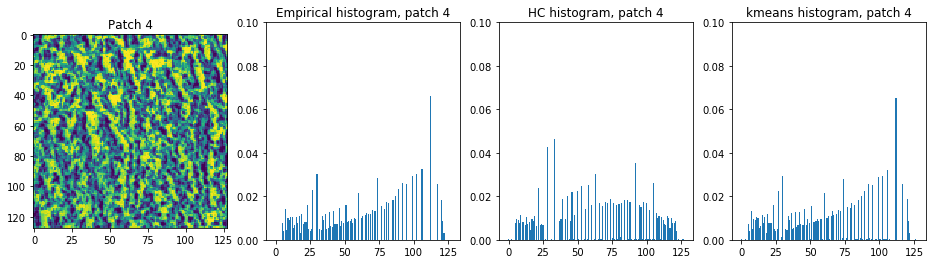

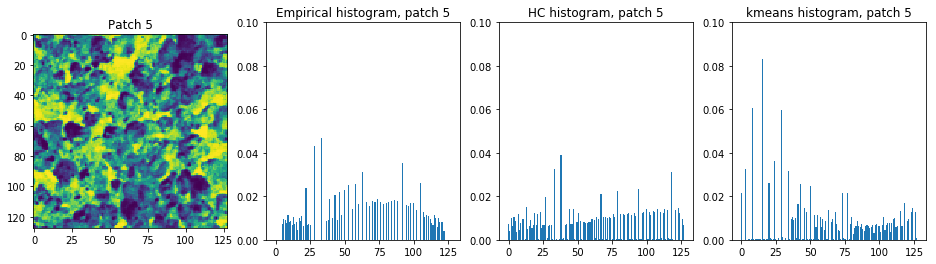

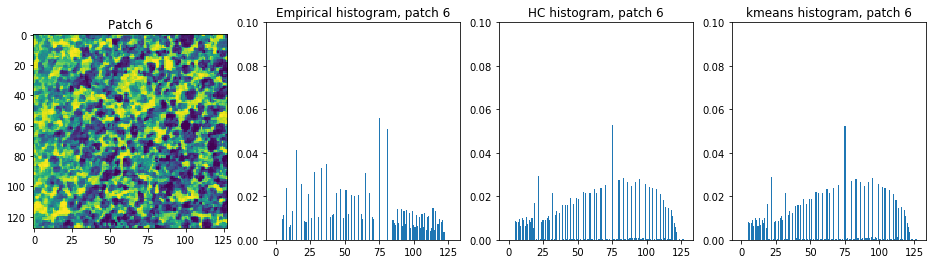

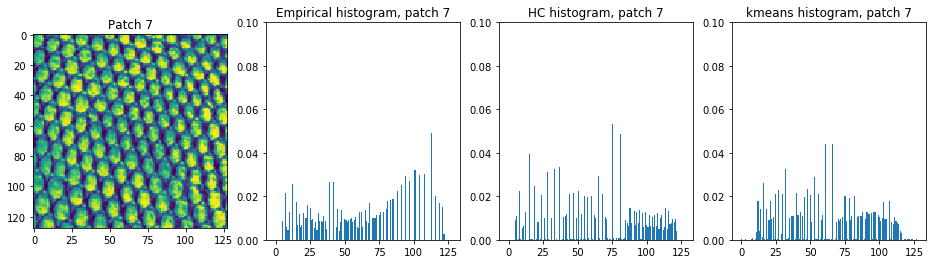

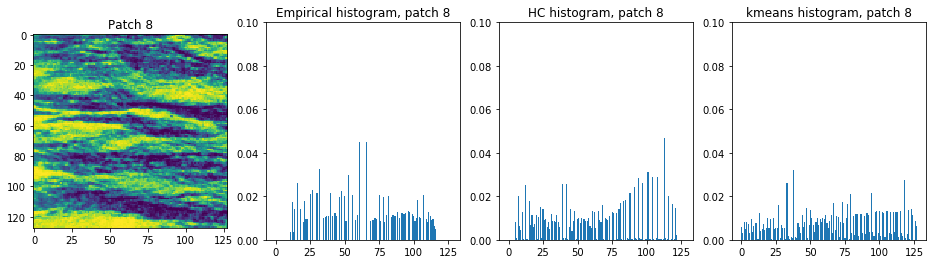

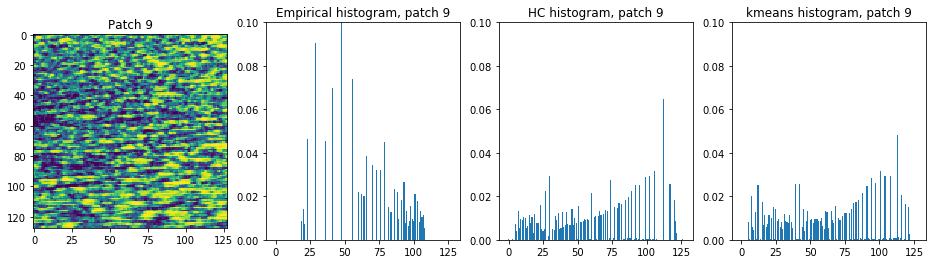

In [96]:
x = range(0, HC0.n_bins)

for id_patch in range(np.prod(patch_grid_shape)):
    
    i, j = np.unravel_index(id_patch, patch_grid_shape)
    patch = texture[patch_shape[0] * i : patch_shape[0] * (i + 1), \
              patch_shape[1] * j : patch_shape[1] * (j + 1)]   
    
    org_hist = HC0.get_hist(patch, normalize=True)
    hc_hist = HC0.centroids[:,id_patch]
    km_hist = kmeans.cluster_centers_[id_patch,:]/np.sum(kmeans.cluster_centers_[id_patch,:])
    
    plt.figure(figsize=(16,4))
    plt.subplot(141)
    plt.imshow(patch)
    plt.title("Patch " + str(id_patch))
    plt.subplot(142)
    plt.bar(x, org_hist)
    plt.ylim((0,0.1))
    plt.title("Empirical histogram, patch " + str(id_patch))
    plt.subplot(143)
    plt.bar(x, hc_hist)
    plt.ylim((0,0.1))
    plt.title("HC histogram, patch " + str(id_patch))
    plt.subplot(144)
    plt.bar(x, km_hist)
    plt.ylim((0,0.1))
    plt.title("kmeans histogram, patch " + str(id_patch))
    plt.show()

In [95]:
np.sum(kmeans.cluster_centers_[1,:])

221.67457077680916

In [81]:
HC0.centroids.shape

(128, 10)

In [70]:
patch_grid_shape

(2, 5)

array([[1.23449282e-02, 1.05205546e-02, 6.17246412e-02, ...,
        0.00000000e+00, 5.33325225e-02, 4.90756507e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.08056189e-03, 3.00156081e-04],
       [5.06258864e-02, 3.72448665e-02, 4.66794105e-02, ...,
        0.00000000e+00, 6.02454215e-02, 9.81069248e-02],
       ...,
       [8.84459670e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.96200561e-02, 3.94269698e-02],
       [1.24284128e+00, 6.80283935e-01, 1.75928340e+00, ...,
        0.00000000e+00, 1.92186972e+00, 1.41643730e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.39647845e-03]])

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

In [ ]:
%%time
HC = HistogramClustering(estimation="DA")
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

0  --- temperature:  0.3
0  --- EM_counter.
0.061649515495660195
1  --- EM_counter.
0.005087996439341177
2  --- EM_counter.
0.002254761799805914
3  --- EM_counter.
0.0012603123014467193
4  --- EM_counter.
0.0008311596850920347
5  --- EM_counter.
0.0006279867707818279
6  --- EM_counter.
0.0005179742065367275
7  --- EM_counter.
0.000447619353933291
8  --- EM_counter.
0.00039592095541231937
9  --- EM_counter.
0.00035448280697413344
10  --- EM_counter.
0.0003196517428392722
11  --- EM_counter.
0.00028960576549523053
12  --- EM_counter.
0.00026328668166932824
13  --- EM_counter.
0.00023999560237696806
14  --- EM_counter.
0.00021922840703964087
15  --- EM_counter.
0.00020060127079389933
16  --- EM_counter.
0.00018381222055412804
17  --- EM_counter.
0.00016861853967377045
18  --- EM_counter.
0.00015482204308220787
19  --- EM_counter.
0.00014225879103347026
20  --- EM_counter.


<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures during the annealing schedule. Describe what you observe.
        </li>
    </ul>

In [ ]:
# Clustering at different temperatures

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.